# Oppgave a)

In [1]:
import sys
sys.path.append('..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [3]:
# import functions from src folder
import data_generation as dg
import gradient_descent as gd
import regression_cost_funcs as rcf
import regression_tools as rt

In [4]:
sb.set_theme()

In this analysis we will evaluate model with MSE after a Gradient descent several times, we therefor consider it clever to employ afunction which with given parameters and data gives us the MSE directly:

In [5]:
def find_MSE(X_train, X_test, z_train, z_test, w_init,
              model, learning_rate, epochs=1000, mode="normal",
                 momentum=0, batch_size=None, store_extra=False):
    
    """Returns the MSE for theese spesifications, works for ridge and lambda regression"""
    
    descent = gd.GradientDescent(mode=mode, momentum_param=momentum, batch_size=batch_size, store_extra=store_extra)
    w = descent.train(X_train, w_init, z_train, model, learning_rate=learning_rate, n_epochs = epochs)
    if store_extra:
        MSE_arr = rt.MSE_vec(z_test, (X_test@descent.weights.T).T)
        return MSE_arr
    else:  
        MSE = rt.MSE(z_test, X_test@w.flatten())
        return MSE

### Generate data from franke function

In [6]:
N = 1000 #nr of data points
x, y, z, true_z = dg.generate_data_Franke(N=N, sigma2=0.1, seed=0)

# Design-matrix
poly_grad = 5
X = rt.create_X_polynomial(x, y, poly_grad)

# Split data:
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.25)

# Scaling problems:
should we or should we not scale the data, and how.

In [7]:
X_train_s = np.ones((len(X_train), len(X_train[0])))
X_test_s = np.ones((len(X_test), len(X_test[0])))
for i in range(20):
    X_train_s[:,i+1] = ( X_train[:,i+1] - np.mean(X_train[:,i+1]) ) / np.std(X_train[:,i+1])
for i in range(20):
    X_test_s[:,i+1] = ( X_test[:,i+1] - np.mean(X_train[:,i+1]) ) / np.std(X_train[:,i+1])

In [8]:
z_train_s = (z_train - np.mean(z_train))/np.std(z_train)
z_test_s = (z_test - np.mean(z_train))/np.std(z_train)

Alternative and equivalent:

In [9]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
z_train_s = scaler.fit_transform(z_train.reshape(-1,1)).flatten()
z_test_s = scaler.transform(z_test.reshape(-1,1)).flatten()

### Analysis of scaling impact on MSE

We find the analytical solution for the scaled and not scaled data and compare the weights as well as MSE

In [11]:
w = rt.ols_regression(X_train, z_train)
MSE = rt.MSE(z_test, X_test@w)

w_s = rt.ols_regression(X_train_s, z_train_s)
MSE_s = rt.MSE(z_test_s, X_test_s@w_s)
print("analytical solutions:")
print("not scaled:", MSE)
print("scaled:", MSE_s)

analytical solutions:
not scaled: 0.011677640064436407
scaled: 0.1265452987470834


In [14]:
print("MSE with zeros as weights:")
print("not scaled:", rt.MSE(z_test, X_test@ np.zeros(len(w_s))))
print("Scaled:", rt.MSE(z_test_s, X_test_s@ np.zeros(len(w_s))))

MSE with zeros as weights:
not scaled: 0.2898159061794116
Scaled: 1.1476724557284947


MSE over 1 in the case of the scaled data can be explained by the std of z_test scaled, which by randomness slighly differs from z_test_s

In [93]:
print(np.std(z_train_s))
print(np.std(z_test_s))

1.0
1.0590396593426805


### Compare with the weights calculated with gradient descent, low learningrate and many iterations.

In [15]:
#konstants
model = rcf.OLSCost()
learning_rate = 0.07
epochs = 50_000
w_init = np.zeros((len(X[0]),1))

In [16]:
# for the unscaled case
descent = gd.GradientDescent(mode="normal", batch_size=None, store_extra=False)
w_descent = descent.train(X_train, w_init, z_train, model, learning_rate=learning_rate, n_epochs = epochs)
MSE_d = rt.MSE(z_test , X_test@w_descent.flatten())

In [17]:
# For the scaled case
descent_scaled = gd.GradientDescent(mode="normal", batch_size=None, store_extra=False)
w_descent_s = descent_scaled.train(X_train_s, w_init, z_train_s, model, learning_rate=learning_rate, n_epochs = epochs)
MSE_d_s = rt.MSE(z_test_s, X_test_s@w_descent_s.flatten())

In [20]:
w = rt.ols_regression(X_train, z_train)
MSE = rt.MSE(z_test, X_test@w)

w_s = rt.ols_regression(X_train_s, z_train_s)
MSE_s = rt.MSE(z_test_s, X_test_s@w_s)

for i in range(len(w_descent)):
    print(f"w[{i}]=", w[i].round(4), f"w_d[{i}]=", w_descent.flatten()[i].round(4) , f"w_s[{i}]",
          w_s[i].round(4), f"w_d_s[{i}]", w_descent_s.flatten()[i].round(4))
    
print(MSE, MSE_d, MSE_s, MSE_d_s)

analytical
w[0]= 0.2071 w_d[0]= 1.0785 w_s[0] 0.0 w_d_s[0] 0.0
w[1]= 9.7758 w_d[1]= -0.6714 w_s[1] 9.2856 w_d_s[1] 1.0467
w[2]= 4.7444 w_d[2]= 0.2096 w_s[2] 4.7169 w_d_s[2] 1.4865
w[3]= -41.672 w_d[3]= -1.1456 w_s[3] -41.3257 w_d_s[3] -6.3499
w[4]= -21.4812 w_d[4]= 1.1925 w_s[4] -16.1132 w_d_s[4] 0.7676
w[5]= -8.8615 w_d[5]= -2.2645 w_s[5] -9.1337 w_d_s[5] -6.41
w[6]= 62.3082 w_d[6]= 0.4159 w_s[6] 59.225 w_d_s[6] 3.2725
w[7]= 55.946 w_d[7]= 0.8219 w_s[7] 37.3862 w_d_s[7] 0.7429
w[8]= 28.5017 w_d[8]= -0.3605 w_s[8] 19.4596 w_d_s[8] -1.3462
w[9]= -12.5164 w_d[9]= -0.4805 w_s[9] -12.3695 w_d_s[9] 1.8776
w[10]= -36.8082 w_d[10]= 0.5853 w_s[10] -33.1183 w_d_s[10] 3.9977
w[11]= -61.7583 w_d[11]= 0.3788 w_s[11] -37.2435 w_d_s[11] 1.6566
w[12]= -18.6367 w_d[12]= -0.0257 w_s[12] -10.6509 w_d_s[12] 0.4567
w[13]= -30.0648 w_d[13]= -0.2747 w_s[13] -18.8592 w_d_s[13] 0.8708
w[14]= 35.3047 w_d[14]= 0.8365 w_s[14] 33.103 w_d_s[14] 4.2834
w[15]= 6.272 w_d[15]= -0.2719 w_s[15] 5.3426 w_d_s[15] -2.9455


### Currenly conlusion of analysis

When we standerize the design matrix with std, in the case of GD we have to choose a whole lot smaler learning rate . This is ilustraded in the plot below where the MSE is plottet over epochs for the stenrides and not for low learning rate

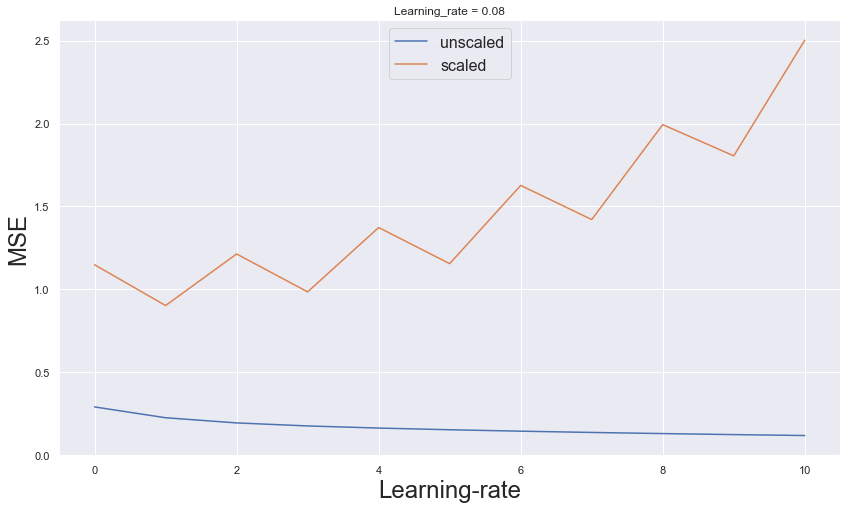

In [98]:
learning_rate = 0.08
model = rcf.RidgeCost(0)
w_init = np.zeros(len(X[0]))
epochs_stop = 10
MSE = np.zeros(epochs_stop+1)
MSE_scaled = np.zeros(epochs_stop+1)

MSE = find_MSE(X_train, X_test, z_train, z_test, w_init, model,
                                   learning_rate=learning_rate, epochs=epochs_stop, store_extra=True, mode="normal")
MSE_scaled = find_MSE(X_train_s, X_test_s, z_train_s, z_test_s, w_init, model,
                                   learning_rate=learning_rate, epochs=epochs_stop, store_extra=True, mode="normal")


plt.figure(figsize=(14,8))
plt.title(f"Learning_rate = {learning_rate}")
plt.plot(np.linspace(0, epochs_stop, epochs_stop+1), MSE, label="unscaled")
plt.plot(np.linspace(0, epochs_stop, epochs_stop+1), MSE_scaled, label="scaled")
plt.xlabel("Learning-rate", fontsize=24)
plt.ylabel("MSE", fontsize=24)
plt.legend(fontsize=16, loc="upper center")
plt.show()

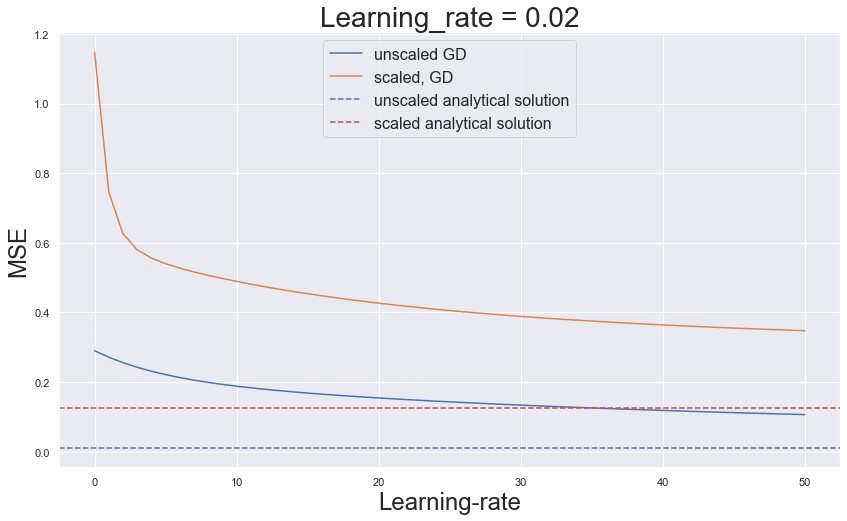

In [99]:
learning_rate = 0.02
model = rcf.RidgeCost(0)
w_init = np.zeros(len(X[0]))
epochs_stop = 50
MSE = np.zeros(epochs_stop+1)
MSE_scaled = np.zeros(epochs_stop+1)
MSE = find_MSE(X_train, X_test, z_train, z_test, w_init, model,
                                   learning_rate=learning_rate, epochs=epochs_stop, store_extra=True, mode="normal")
MSE_scaled = find_MSE(X_train_s, X_test_s, z_train_s, z_test_s, w_init, model,
                                   learning_rate=learning_rate, epochs=epochs_stop, store_extra=True, mode="normal")

MSE_analytic = rt.MSE(z_test, X_test@rt.ols_regression(X_train, z_train))
MSE_scaled_analytic =rt.MSE(z_test_s, X_test_s@rt.ols_regression(X_train_s, z_train_s))

plt.figure(figsize=(14,8))
plt.title(f"Learning_rate = {learning_rate}", fontsize=28)
plt.plot(np.linspace(0, epochs_stop, epochs_stop+1), MSE, label="unscaled GD")
plt.plot(np.linspace(0, epochs_stop, epochs_stop+1), MSE_scaled, label="scaled, GD")
plt.axhline(MSE_analytic, linestyle="--", label="unscaled analytical solution")
plt.axhline( MSE_scaled_analytic, linestyle="--", label="scaled analytical solution", color="r")
plt.xlabel("Learning-rate", fontsize=24)
plt.ylabel("MSE", fontsize=24)
plt.legend(fontsize=16, loc="upper center")
plt.show()

In the futher analysis we would assume a standar scaling of the data, in line with sklean's StandarScaler() function. Therefor we expecting small learning-rates, estimated below 0.1.

In [31]:
N = 1000 #nr of data points
x, y, z, true_z = dg.generate_data_Franke(N=N, sigma2=0.1, seed=0)

# Design-matrix
poly_grad = 5
X = rt.create_X_polynomial(x, y, poly_grad)

# Split data and scale:
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.25)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
z_train = scaler.fit_transform(z_train.reshape(-1,1)).flatten()
z_test = scaler.transform(z_test.reshape(-1,1)).flatten()

# Gradient Descent anlysis:

Plot MSE as a function of learning-rate for OLS and Ridge (with a few different regularisation values)

In [32]:
w_init = np.zeros(len(X[0]))
epochs = 1000

In [33]:
# OLS and Ridge:
lambda_values = [0, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 1]
lr_range = np.linspace(0, 0.2, 50)
MSE_Ridge = np.zeros((len(lambda_values), len(lr_range)))

for i, lambdaer in enumerate(lambda_values):
    model = rcf.RidgeCost(lambdaer)
    for j, lr in enumerate(lr_range):
        MSE_Ridge[i, j] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, lr, epochs=epochs, mode="normal")
        
        """ Implementation of settig MSE to nan if MSE[j]>... and break """
        if MSE_Ridge[i, j] > MSE_Ridge[i, 0]+5:
            for index in range(j, len(lr_range)): MSE_Ridge[i, index] = np.NaN
            break

## Plot 1 - 1000 n_epochs:

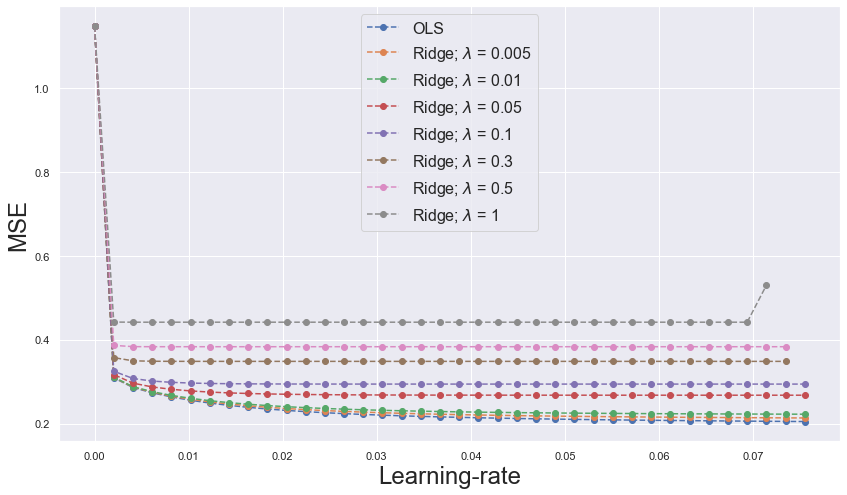

In [34]:
plt.figure(figsize=(14,8))
for i, lambdaer in enumerate(lambda_values):
    if lambdaer == 0:
        plt.plot(lr_range, MSE_Ridge[i], "--o", label=f"OLS")
    else:
        plt.plot(lr_range, MSE_Ridge[i], "--o", label=fr"Ridge; $\lambda$ = {lambdaer}")
plt.xlabel("Learning-rate", fontsize=24)
plt.ylabel("MSE", fontsize=24)
plt.legend(fontsize=16, loc="upper center")
plt.show()

In [35]:
# Estimated divergence learning-rates for epochs : 1000
print(f"An estimate for the lagrgest learning rate we could choose before the GD diverges,")
print(f"for an given lambda is")
print("---------------------------------")

print(f"n_epochs = {epochs} :")
print("Lambda -- Learning-rate -- Min MSE")
print("----------------------------------")
for i, lambdaer in enumerate(lambda_values):
    arr = MSE_Ridge[i]
    print(f"{lambdaer:.3f}       {lr_range[ len(arr[~np.isnan(arr)]) - 1] : .3f}       {np.nanmin(MSE_Ridge[i]):.3f}")
    

An estimate for the lagrgest learning rate we could choose before the GD diverges,
for an given lambda is
---------------------------------
n_epochs = 1000 :
Lambda -- Learning-rate -- Min MSE
----------------------------------
0.000        0.076       0.205
0.005        0.076       0.213
0.010        0.076       0.222
0.050        0.076       0.268
0.100        0.076       0.294
0.300        0.073       0.348
0.500        0.073       0.383
1.000        0.071       0.442


# For n_epochs 500 and 100 and 50

We now do a simmelar analysis to investigate how the number of epochs will change the result

In [36]:
print(f"An estimate for the lagrgest learning rate we could choose before the GD diverges,")
print(f"for an given lambda is")
print("---------------------------------")


# OLS and Ridge:
epochs = 500
lambda_values = [0, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 1]
lr_range = np.linspace(0.001, 0.7, 100)
MSE_Ridge = np.zeros((len(lambda_values), len(lr_range)))

for i, lambdaer in enumerate(lambda_values):
    model = rcf.RidgeCost(lambdaer)
    for j, lr in enumerate(lr_range):
        MSE_Ridge[i, j] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, lr, epochs=epochs)
        """ Implementation of settig MSE to nan if MSE>1"""
        if MSE_Ridge[i, j] > MSE_Ridge[i, 0]:
            for index in range(j, len(lr_range)): MSE_Ridge[i, index] = np.NaN
            break




print(f"n_epochs = {epochs} :")
print("Lambda -- Learning-rate -- Min MSE")
print("----------------------------------")
for i, lambdaer in enumerate(lambda_values):
    arr = MSE_Ridge[i]
    print(f"{lambdaer:.3f}       {lr_range[ len(arr[~np.isnan(arr)]) - 1] : .3f}       {np.nanmin(MSE_Ridge[i]):.3f}")

epochs = 100
lambda_values = [0, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 1]
lr_range = np.linspace(0.001, 0.7, 100)
MSE_Ridge = np.zeros((len(lambda_values), len(lr_range)))

for i, lambdaer in enumerate(lambda_values):
    model = rcf.RidgeCost(lambdaer)
    for j, lr in enumerate(lr_range):
        MSE_Ridge[i, j] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, lr,epochs=epochs)
        """ Implementation of settig MSE to nan if MSE>1"""
        if MSE_Ridge[i, j] > MSE_Ridge[i, 0]:
            for index in range(j, len(lr_range)): MSE_Ridge[i, index] = np.NaN
            break
            
print(f"n_epochs = {epochs} :")
print("Lambda -- Learning-rate -- Min MSE")
print("----------------------------------")
for i, lambdaer in enumerate(lambda_values):
    arr = MSE_Ridge[i]
    print(f"{lambdaer:.3f}       {lr_range[ len(arr[~np.isnan(arr)]) - 1] : .3f}       {np.nanmin(MSE_Ridge[i]):.3f}")

    
epochs = 50
lambda_values = [0, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 1]
lr_range = np.linspace(0.001, 0.7, 100)
MSE_Ridge = np.zeros((len(lambda_values), len(lr_range)))

for i, lambdaer in enumerate(lambda_values):
    model = rcf.RidgeCost(lambdaer)
    for j, lr in enumerate(lr_range):
        MSE_Ridge[i, j] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, lr, epochs=epochs)
        """ Implementation of settig MSE to nan if MSE>1"""
        if MSE_Ridge[i, j] > MSE_Ridge[i, 0]:
            for index in range(j, len(lr_range)): MSE_Ridge[i, index] = np.NaN
            break
            
print(f"n_epochs = {epochs} :")
print("Lambda -- Learning-rate -- Min MSE")
print("----------------------------------")
for i, lambdaer in enumerate(lambda_values):
    arr = MSE_Ridge[i]
    print(f"{lambdaer:.3f}       {lr_range[ len(arr[~np.isnan(arr)]) - 1] : .3f}       {np.nanmin(MSE_Ridge[i]):.3f}")

    
epochs = 10
lambda_values = [0, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 1]
lr_range = np.linspace(0.001, 0.7, 100)
MSE_Ridge = np.zeros((len(lambda_values), len(lr_range)))

for i, lambdaer in enumerate(lambda_values):
    model = rcf.RidgeCost(lambdaer)
    for j, lr in enumerate(lr_range):
        MSE_Ridge[i, j] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, lr, epochs=epochs)
        """ Implementation of settig MSE to nan if MSE>1"""
        if MSE_Ridge[i, j] > MSE_Ridge[i, 0]:
            for index in range(j, len(lr_range)): MSE_Ridge[i, index] = np.NaN
            break
            
print(f"n_epochs = {epochs} :")
print("Lambda -- Learning-rate -- Min MSE")
print("----------------------------------")
for i, lambdaer in enumerate(lambda_values):
    arr = MSE_Ridge[i]
    print(f"{lambdaer:.3f}       {lr_range[ len(arr[~np.isnan(arr)]) - 1] : .3f}       {np.nanmin(MSE_Ridge[i]):.3f}")

An estimate for the lagrgest learning rate we could choose before the GD diverges,
for an given lambda is
---------------------------------
n_epochs = 500 :
Lambda -- Learning-rate -- Min MSE
----------------------------------
0.000        0.072       0.216
0.005        0.072       0.223
0.010        0.072       0.229
0.050        0.072       0.268
0.100        0.072       0.294
0.300        0.072       0.348
0.500        0.072       0.383
1.000        0.065       0.442
n_epochs = 100 :
Lambda -- Learning-rate -- Min MSE
----------------------------------
0.000        0.072       0.268
0.005        0.072       0.270
0.010        0.072       0.271
0.050        0.072       0.284
0.100        0.072       0.299
0.300        0.072       0.348
0.500        0.072       0.383
1.000        0.065       0.442
n_epochs = 50 :
Lambda -- Learning-rate -- Min MSE
----------------------------------
0.000        0.072       0.290
0.005        0.072       0.291
0.010        0.072       0.291
0.050      

# SGD - Stochastic Gradient Descent - Batch size = 1
And now compare with SKlearn.
In Stochastic Gradient Descent we can choose a parameter called mini-batches.

For SKlearn we dont have this oppertuntity, we therrefor do one plot of MSE over learningrate for SGD with minibatches=1

We want to plot MSE for OLS and 

Choose lambda = 0.01

In [43]:
w_init = np.zeros(len(X[0]))
lambdaen = 0.01
model = rcf.RidgeCost(lambdaen)

epochs_range = [5, 10, 1000]
lr_range = np.linspace(0.0001, 0.1, 50)
MSE_Ridge = np.zeros((len(epochs_range), len(lr_range)))
MSE_SKlearn = np.zeros((len(epochs_range), len(lr_range)))
for i, epochs in enumerate(epochs_range):
    for j, lr in enumerate(lr_range):
        MSE_Ridge[i, j] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, lr, epochs=epochs, batch_size=1)
        
     
        """ Implementation of settig MSE to nan if MSE[j]>MSE[j=0] """
        if MSE_Ridge[i, j] > (MSE_Ridge[i, 0]+1):
            for index in range(j, len(lr_range)): MSE_Ridge[i, index] = np.NaN
            break
 
    for j, lr in enumerate(lr_range):
        sk_model = skl.SGDRegressor(loss="squared_loss", alpha=lambdaen, 
                                    max_iter=epochs, tol=None, learning_rate="constant", eta0=lr)
        sk_model.fit(X_train, z_train)
        z_pred_SK = sk_model.predict(X_test)
        MSE_SKlearn[i, j] = rt.MSE(z_test, z_pred_SK)
        if MSE_SKlearn[i, j] > (MSE_SKlearn[i, 0]+1):
            for index in range(j, len(lr_range)): MSE_SKlearn[i, index] = np.NaN
            break
        

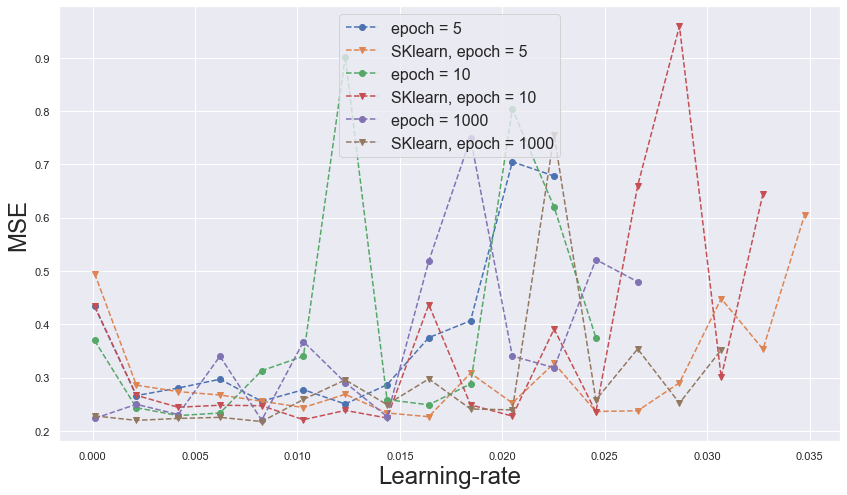

In [44]:
plt.figure(figsize=(14,8))
for i, epochs in enumerate(epochs_range):
    plt.plot(lr_range, MSE_Ridge[i], "--o", label=fr"epoch = {epochs}")
    plt.plot(lr_range, MSE_SKlearn[i], "--v", label=fr"SKlearn, epoch = {epochs}")
plt.xlabel("Learning-rate", fontsize=24)
plt.ylabel("MSE", fontsize=24)
plt.legend(fontsize=16, loc="upper center")
plt.show()

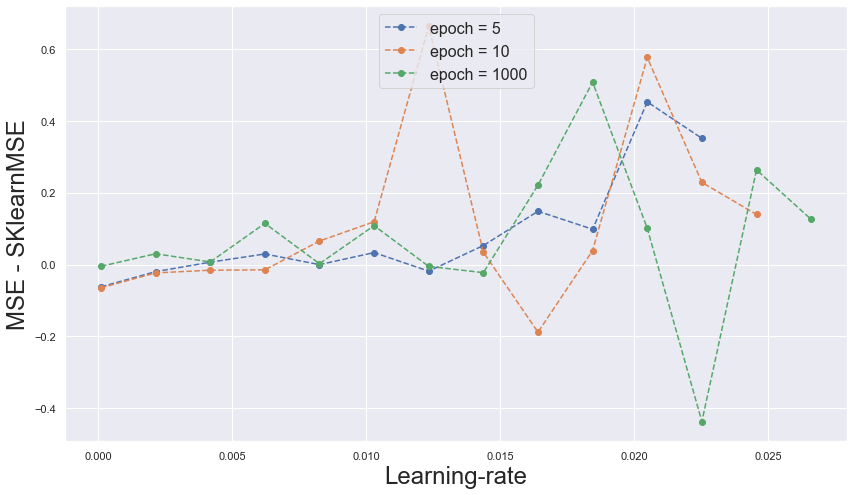

In [45]:
plt.figure(figsize=(14,8))
for i, epochs in enumerate(epochs_range):
    plt.plot(lr_range, (MSE_Ridge[i] - MSE_SKlearn[i]), "--o", label=fr"epoch = {epochs}")
plt.xlabel("Learning-rate", fontsize=24)
plt.ylabel("MSE - SKlearnMSE", fontsize=24)
plt.legend(fontsize=16, loc="upper center")
plt.show()

### Do as over but plot over epochs for different learning-rates

In [77]:
w_init = np.zeros(len(X[0]))
lambdaen = 0.01
model = rcf.RidgeCost(lambdaen)

epochs_stop = 1000
lr_range = [0.0001, 0.001, 0.005]
MSE_SG = np.zeros((len(lr_range), epochs_stop+1))
MSE_GD = np.zeros((len(lr_range), epochs_stop+1))
for i, lr in enumerate(lr_range):
    MSE_SG[i] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, lr,
                               epochs=epochs_stop, batch_size=1, store_extra=True)
    MSE_GD[i] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, lr,
                               epochs=epochs_stop, store_extra=True)


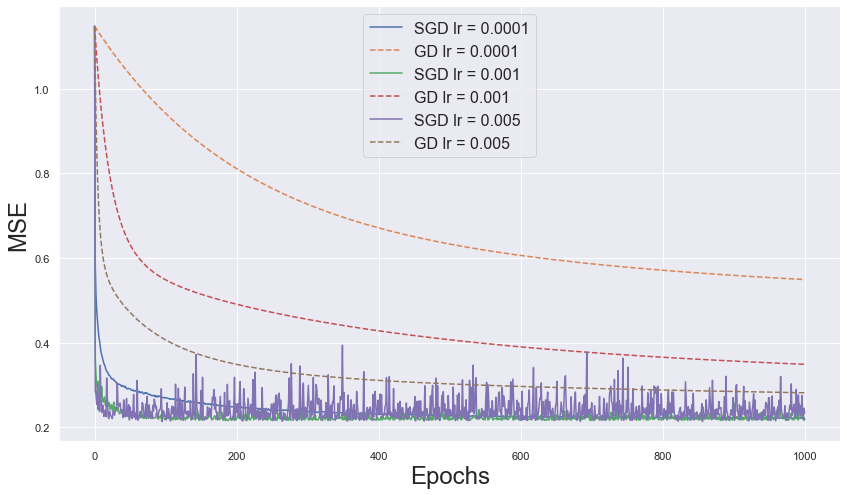

In [78]:
plt.figure(figsize=(14,8))
for i, lr in enumerate(lr_range[:]):
    plt.plot(np.linspace(0, epochs_stop, epochs_stop+1), MSE_SG[i], label=fr"SGD lr = {lr}")
    plt.plot(np.linspace(0, epochs_stop, epochs_stop+1), MSE_GD[i], "--" ,label=fr"GD lr = {lr}")
plt.xlabel("Epochs", fontsize=24)
plt.ylabel("MSE", fontsize=24)
plt.legend(fontsize=16, loc="upper center")
plt.show()

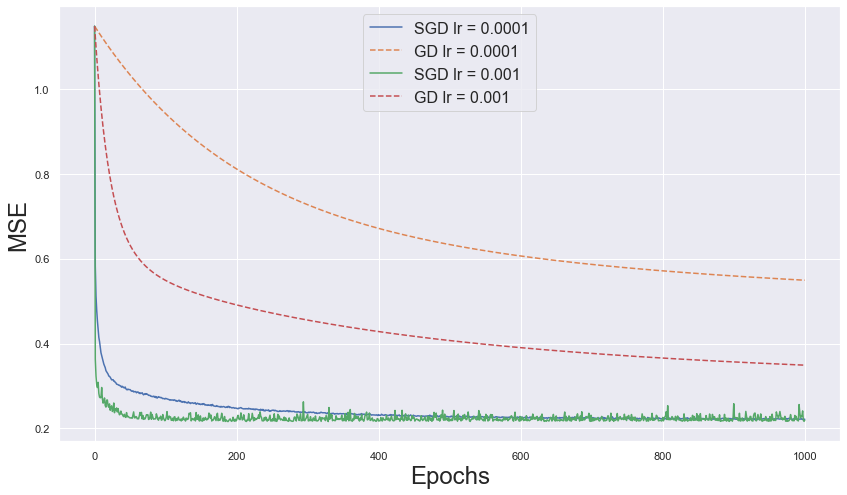

In [79]:
plt.figure(figsize=(14,8))
for i, lr in enumerate(lr_range[:2]):
    plt.plot(np.linspace(0, epochs_stop, epochs_stop+1), MSE_SG[i], label=fr"SGD lr = {lr}")
    plt.plot(np.linspace(0, epochs_stop, epochs_stop+1), MSE_GD[i], "--" ,label=fr"GD lr = {lr}")
plt.xlabel("Epochs", fontsize=24)
plt.ylabel("MSE", fontsize=24)
plt.legend(fontsize=16, loc="upper center")
plt.show()

Conclusions of the above: Whith SGD aka batch size = 1 we need even smaller learning rate. somewhere around 0.001

## Analyze MSE development over epochs for different batch-sizes

We now want a range of bach sizes. For computational renons we want batch sizes to be an power of 2.
A list with $[8, 32, 128, 256]$  Choose a learning-rate of 0.05, by investigating the plot above, where batch_size = 1.
We do this for OLSCost.

In [72]:
batch_sizes = np.array([8, 32, 128, 256])
learning_rate = 0.005
model = rcf.OLSCost()
w_init = np.zeros(len(X[0]))

epochs_stop = 750
lr_range = np.linspace(0.001, 0.003, 20)
MSE = np.zeros((len(batch_sizes), epochs_stop+1))
for i, b_size in enumerate(batch_sizes):
    MSE[i] = find_MSE(X_train, X_test, z_train, z_test, w_init, model,
                                   learning_rate=learning_rate, epochs=epochs_stop, batch_size=b_size, store_extra=True)

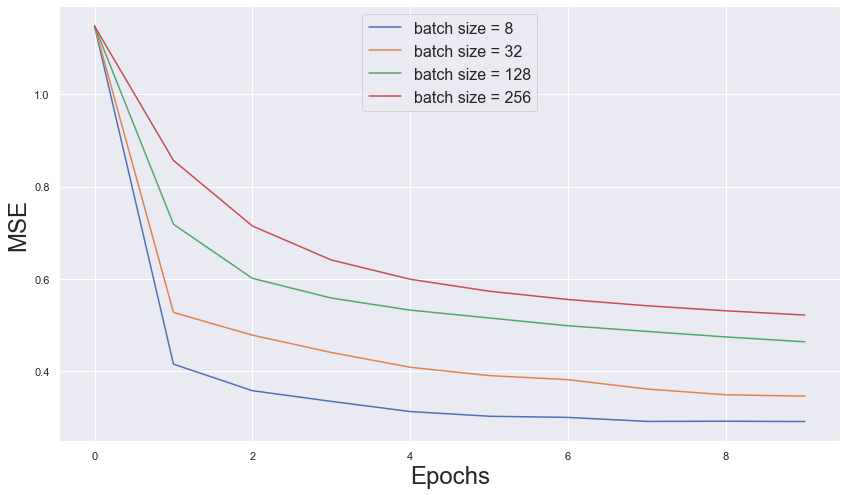

In [75]:
plt.figure(figsize=(14,8))
for i, b in enumerate(batch_sizes):
    plt.plot(np.linspace(0, 750, 751)[:10], MSE[i][:10], label=fr"batch size = {b}")
plt.xlabel("Epochs", fontsize=24)
plt.ylabel("MSE", fontsize=24)
plt.legend(fontsize=16, loc="upper center")
plt.show()

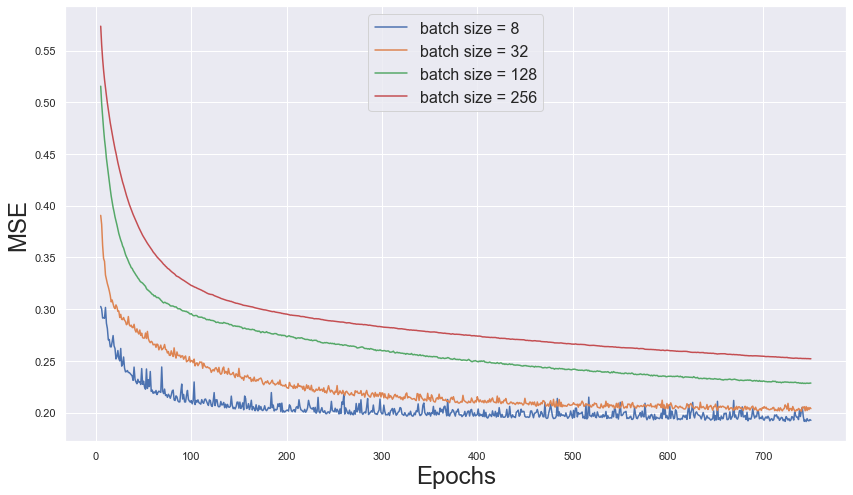

In [73]:
plt.figure(figsize=(14,8))
for i, b in enumerate(batch_sizes):
    plt.plot(np.linspace(0, 750, 751)[5:], MSE[i][5:], label=fr"batch size = {b}")
plt.xlabel("Epochs", fontsize=24)
plt.ylabel("MSE", fontsize=24)
plt.legend(fontsize=16, loc="upper center")
plt.show()

## Now with 10_000 datapoints to see impact

In [80]:
N = 10_000 #nr of data points
x, y, z, true_z = dg.generate_data_Franke(N=N, sigma2=0.1, seed=0)

poly_grad = 5
X = rt.create_X_polynomial(x, y, poly_grad)

# Split data:
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.25)

# Split data:
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.25)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
z_train = scaler.fit_transform(z_train.reshape(-1,1)).flatten()
z_test = scaler.transform(z_test.reshape(-1,1)).flatten()

In [233]:
batch_sizes = np.array([8, 64, 128, 1024])
learning_rate = 0.02
model = rcf.OLSCost()
w_init = np.zeros(len(X[0]))

epochs_stop = 2000
MSE = np.zeros((len(batch_sizes), epochs_stop+1))

for i, b_size in enumerate(batch_sizes):
    MSE[i] = find_MSE(X_train, X_test, z_train, z_test, w_init, model,
                                   learning_rate=learning_rate, epochs=epochs_stop, batch_size=b_size, store_extra=True)
        

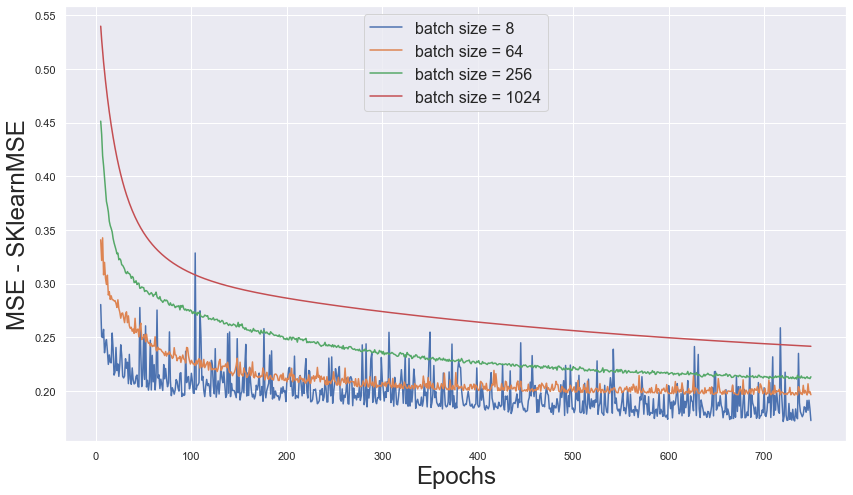

In [170]:
plt.figure(figsize=(14,8))
for i, b in enumerate(batch_sizes):
    plt.plot(np.linspace(0, epochs_stop, epochs_stop+1)[5:750], MSE[i][5:750], label=fr"batch size = {b}")
plt.xlabel("Epochs", fontsize=24)
plt.ylabel("MSE - SKlearnMSE", fontsize=24)
plt.legend(fontsize=16, loc="upper center")
plt.show()

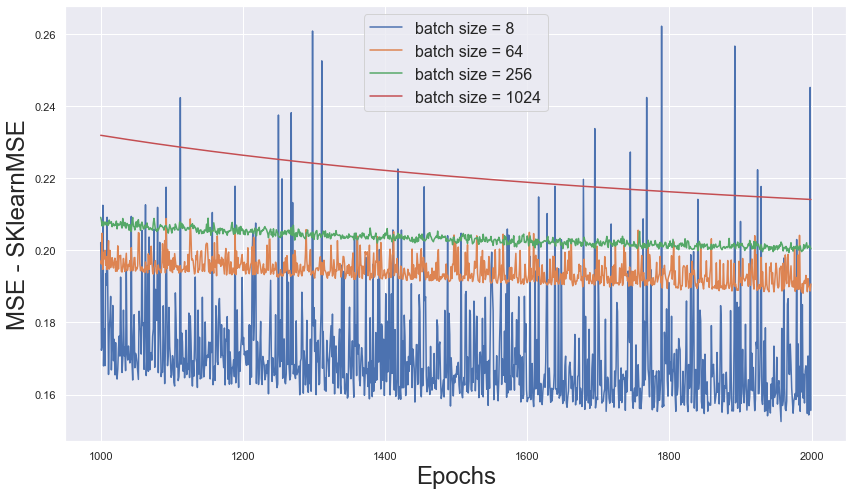

In [169]:
plt.figure(figsize=(14,8))
for i, b in enumerate(batch_sizes):
    plt.plot(np.linspace(0, epochs_stop, epochs_stop+1)[1000:2000], MSE[i][1000:2000], label=fr"batch size = {b}")
plt.xlabel("Epochs", fontsize=24)
plt.ylabel("MSE - SKlearnMSE", fontsize=24)
plt.legend(fontsize=16, loc="upper center")
plt.show()

# Momentum Analysis

In [122]:
#Choose Data:
N = 1000 #nr of data points
x, y, z, true_z = dg.generate_data_Franke(N=N, sigma2=0.1, seed=0)

poly_grad = 5
X = rt.create_X_polynomial(x, y, poly_grad)

# Split and scale data:
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.25)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
z_train = scaler.fit_transform(z_train.reshape(-1,1)).flatten()
z_test = scaler.transform(z_test.reshape(-1,1)).flatten()

In [226]:
batch_size = 128 #set a bach_size based on previos analysis
mode = "normal"
learning_rates = np.array([0.001, 0.005, 0.01, 0.05])
epochs = 2000
momentum_parms = np.linspace(0, 0.999, 100)
model = rcf.OLSCost()
w_init = np.zeros(len(X[0]))
MSE = np.zeros((len(learning_rates), len(momentum_parms) ))

for i, lr in enumerate(learning_rates):   
    for j, mom in enumerate(momentum_parms):
        MSE[i, j] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, lr, epochs=epochs, momentum=mom)
        """ Implementation of settig MSE to nan if MSE[j] > MSE[0] + ...
        if MSE[i, j] > MSE[i, 0]+ 0.5:
            for index in range(j, len(lr_range)): MSE_Ridge[i, index] = np.NaN
            break
        """

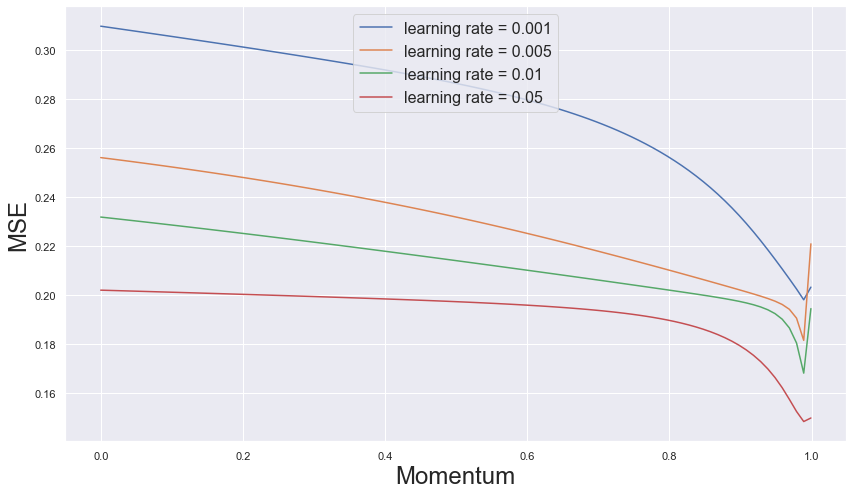

In [227]:
plt.figure(figsize=(14,8))
for i, lr in enumerate(learning_rates):
    plt.plot(momentum_parms, MSE[i], label=fr"learning rate = {lr}")
plt.xlabel("Momentum", fontsize=24)
plt.ylabel("MSE", fontsize=24)
plt.legend(fontsize=16, loc="upper center")
plt.show()

In [232]:
for i in range(len(learning_rates)):
    print("Lr:", learning_rates[i])
    print("min MSE:", np.min(MSE[i]))
    print("whith momentum:", momentum_parms[np.argmin(MSE[i])])

Lr: 0.001
min MSE: 0.19809448988456996
whith momentum: 0.988909090909091
Lr: 0.005
min MSE: 0.18151943333158835
whith momentum: 0.988909090909091
Lr: 0.01
min MSE: 0.1681330572278772
whith momentum: 0.988909090909091
Lr: 0.05
min MSE: 0.14836013044668184
whith momentum: 0.988909090909091


# Previous mom analysis, updated:

In [144]:
batch_size = 128
model = rcf.RidgeCost(0)
w_init = np.zeros(len(X[0]))
epochs = 1000

# We want two models of gradient decent; None, large and small mom
mom_arr = [0.1,0.5, 0.9 , 0.99]
MSE_arr = np.zeros((len(mom_arr), epochs+1))

for i, mom in enumerate(mom_arr):
    MSE_arr[i] = find_MSE(X_train, X_test, z_train, z_test, w_init, model,
                      learning_rate=0.05, epochs=epochs, momentum=mom, store_extra=True)

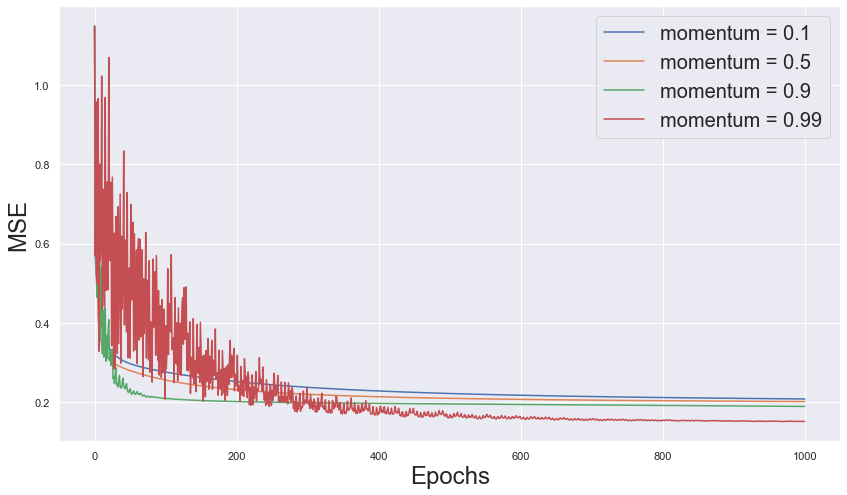

In [145]:
plt.figure(figsize=(14,8))
for i, mom in enumerate(mom_arr):
    plt.plot(np.linspace(0, epochs, epochs+1), MSE_arr[i], label=fr"momentum = {mom}")
plt.xlabel("Epochs", fontsize=24)
plt.ylabel("MSE", fontsize=24)
plt.legend(fontsize=20)
plt.show()

## Compered to SKlearn:  ToDo

### What with momentum larger then 1?

In [223]:
batch_size = 128
model = rcf.RidgeCost(0)
w_init = np.zeros(len(X[0]))
epochs = 1000

# We want two models of gradient decent; None, large and small mom
mom_arr = [1, 1.002]
MSE_arr = np.zeros((len(mom_arr), epochs+1))

for i, mom in enumerate(mom_arr):
    MSE_arr[i] = find_MSE(X_train, X_test, z_train, z_test, w_init, model,
                      learning_rate=0.05, epochs=epochs, momentum=mom, store_extra=True)

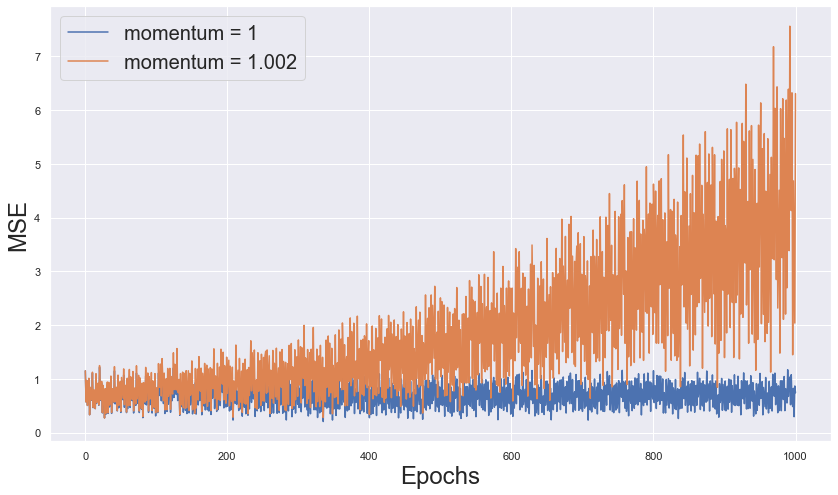

In [224]:
plt.figure(figsize=(14,8))
for i, mom in enumerate(mom_arr):
    plt.plot(np.linspace(0, epochs, epochs+1), MSE_arr[i], label=fr"momentum = {mom}")
plt.xlabel("Epochs", fontsize=24)
plt.ylabel("MSE", fontsize=24)
plt.legend(fontsize=20)
plt.show()

This analasys gives a estimate of an optimal model whith the following parameters:
Learning rate $= 0.05$
Batch size $= 128$
Momentum $= 0.99$
Theese where found only by looking at what we saw as reasonable parameters in our plots,
to do a more detatailed search for parameters one would do a grid search. Whith mode nomal.

# Different modes

Modes like adam, adagrad and rms-prop would adjust the learning rate. We would like to investigate how this affect out models preformence compered to mode "normal" where we don't adjust the learningrate.

There are some things more interesting than other:

1. Learning rate analysis:

    * For each mode plot MSE over Epochs for 5 different lr with OLS reg - might not be so interesting
    
    * Plot MSE over learningrates for each mode with OLS reg
    
    * Same as over but with some lambda values - aka 4 sub-plots  #TODO 
    
    
2. The SGD - Batch-size analysis:
    
    * Four plots for each mode batch size = 1 for a few different learningrates MSE over Epochs 
    
    * Four plots (for each mode) MSE over learning rate for 64, 128 and 256
    
    * MSE over epochs for batch_size 64, 128, 256 - Fixed learning rate - might differ
    
    
3. Momentum analysis:

    * MSE over momentum 4 plots (Equal Axis) for a few different learning rates 
    
    * MSE over Epochs 4 plots (Equal Axis) for a few different momentum set learing rates   
    
    
4. SKlearn:
    
    * TODO: Find out where a comperison with SKlearn could be relevant. 

5. Grid search: (random/limited area)
    
    * Four plots, grid search for lambda and learningrate
    
    * Plot with seaborn

In [234]:
# Generate data for this whole analysis part:
N = 1000 #nr of data points
x, y, z, true_z = dg.generate_data_Franke(N=N, sigma2=0.1, seed=0)

# Design-matrix
poly_grad = 5
X = rt.create_X_polynomial(x, y, poly_grad)

# Split data and scale:
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.25)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
z_train = scaler.fit_transform(z_train.reshape(-1,1)).flatten()
z_test = scaler.transform(z_test.reshape(-1,1)).flatten()

We should bring back the analytical solution we retain by the ols regression:

In [237]:
# Analytical solution:
weights = rt.ols_regression(X_train, z_train)
MSE_analytical_ols = rt.MSE(z_test, X_test@weights)
print("MSE from analytical solutions:")
print(MSE_analytical_ols.round(3))

MSE from analytical solutions:
0.127


This will be a benchmark for the futher analysis. 

# 1. Learning-rate analysis for the four mode's

## OLS, MSE over Epochs
We do this for the four mode's and for different learning rates

In [598]:
modes = ["normal", "adam", "rmsprop", "adagrad"]
n_features = len(X_train[0])
init_weights = np.zeros(n_features)
model = rcf.RidgeCost(0) #The same as rcf.OLSCost()

epochs_stop = 50_000
n_epochs = epochs_stop + 1
epochs_linspace = np.linspace(0, epochs_stop, n_epochs, dtype=int) #to use in plot
learning_rates = [0.001, 0.01, 0.04, 0.1]
n_lr = len(learning_rates)

MSE_normal = np.zeros((n_lr, n_epochs))
MSE_adam = np.zeros((n_lr, n_epochs))
MSE_rmsprop = np.zeros((n_lr, n_epochs))
MSE_adagrad = np.zeros((n_lr, n_epochs))
MSE_modes = [MSE_normal, MSE_adam, MSE_rmsprop, MSE_adagrad] #use when plotting

for j, MSE_mode in enumerate(MSE_modes):
    for i, lr in enumerate(learning_rates):
        MSE_mode[i] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, 
                             mode=modes[j],learning_rate=lr, 
                             epochs=epochs_stop, store_extra=True)

/Users/halvortyseng/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:178: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/halvortyseng/Desktop/FYS-STK3155-project-2/notebooks/../regression_cost_funcs.py:138: RuntimeWarning: overflow encountered in square
  return np.mean((X @ w - y) ** 2) + self.regularization * np.sum(w ** 2)
/Users/halvortyseng/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/halvortyseng/Desktop/FYS-STK3155-project-2/notebooks/../regression_cost_funcs.py:138: RuntimeWarning: invalid value encountered in double_scalars
  return np.mean((X @ w - y) ** 2) + self.regularization * np.sum(w ** 2)
/Users/halvortyseng/Desktop/FYS-STK3155-project-2/notebooks/../regression_cost_funcs.py:138: RuntimeWarning: overflow encountered in matmul
  return np.mean((X @ 

TypeError: savefig() missing 1 required positional argument: 'fname'

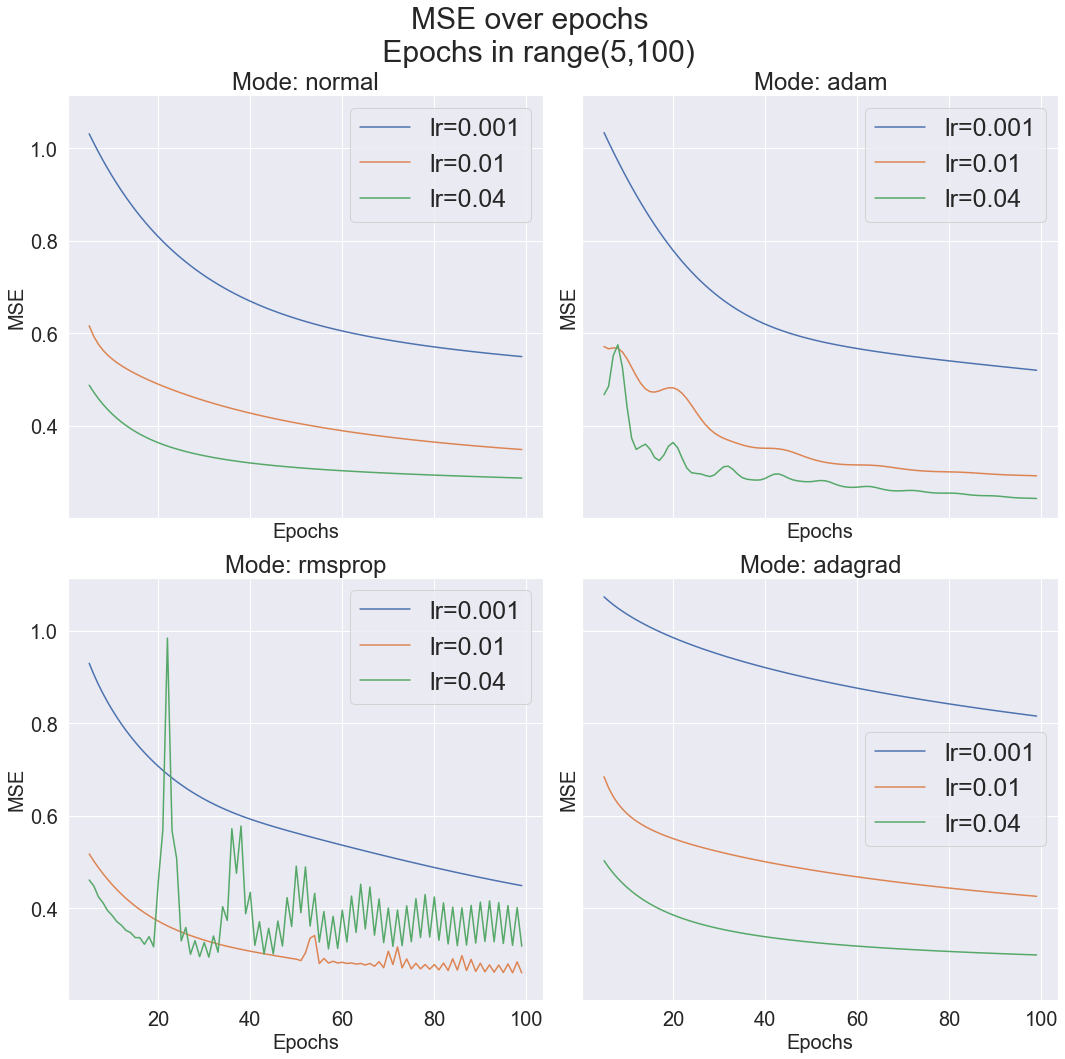

In [618]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
fig.set_figheight(15)
fig.set_figwidth(15)

start = 5; stop = 100
fig.suptitle(f"MSE over epochs \n Epochs in range({start},{stop})", fontsize=30)
for i, ax in enumerate(axs.flatten()):
    ax.set_xlabel("Epochs", fontsize=20)
    ax.set_ylabel("MSE", fontsize=20)
    ax.set_title(f"Mode: {modes[i]}", fontsize=24)
    ax.tick_params(labelsize=20)
    for j, lr in enumerate(learning_rates[:-1]):
        ax.plot(epochs_linspace[start:stop], MSE_modes[i][j][start:stop], label=f"lr={lr}")
    ax.legend(fontsize=25)
plt.tight_layout()
plt.savefig("../results/")

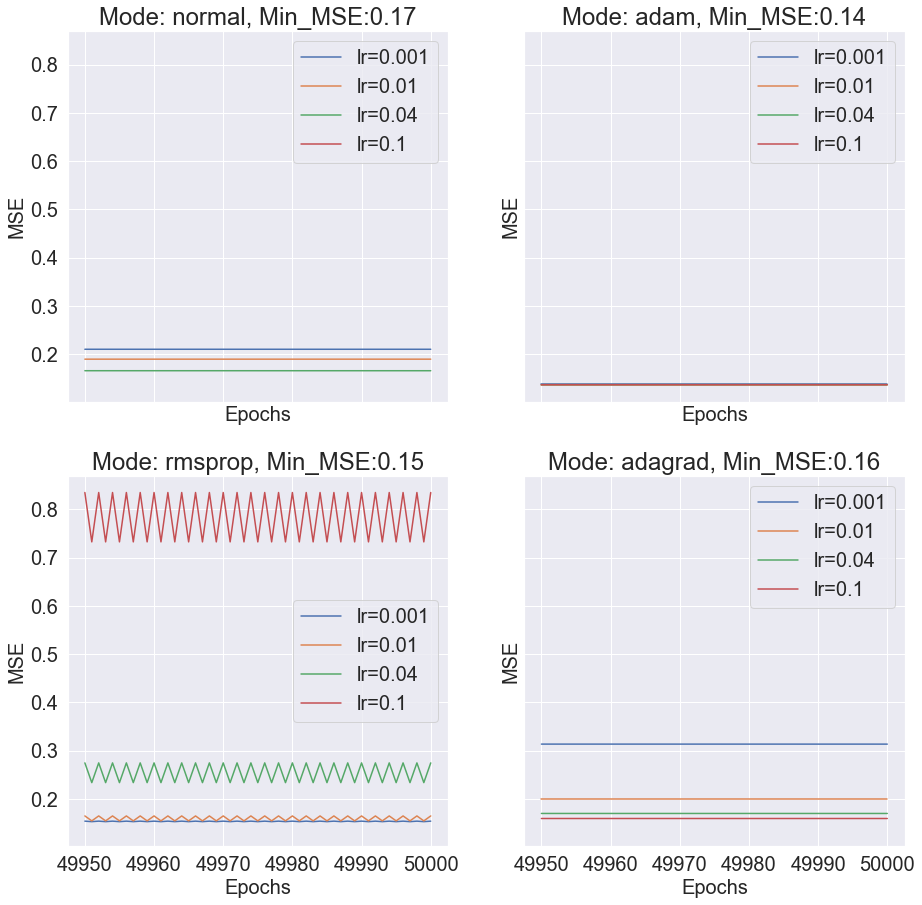

In [609]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
fig.set_figheight(15)
fig.set_figwidth(15)
for i, ax in enumerate(axs.flatten()):
    ax.set_xlabel("Epochs", fontsize=20)
    ax.set_ylabel("MSE", fontsize=20)
    ax.set_title(f"Mode: {modes[i]}, Min_MSE:{np.nanmin(MSE_modes[i]):.2f}", fontsize=24)
    ax.tick_params(labelsize=20)
    for j, lr in enumerate(learning_rates):
        ax.plot(epochs_linspace[49950:], MSE_modes[i][j][49950:], label=f"lr={lr}")
    ax.legend(fontsize=20)

## MSE over learningrate
In this case we have to set a limit on the epochs, n_epochs = $...$. 

We implement so when the MSE diverges above a limit, the case is discarded, and the value is set to "NaN" so the plotting will work out.

In [372]:
epochs_stop = 1000
learning_rates = np.linspace(0.0001, 0.9)
n_lr = len(learning_rates)

MSE_normal = np.zeros(n_lr)
MSE_adam = np.zeros(n_lr)
MSE_rmsprop = np.zeros(n_lr)
MSE_adagrad = np.zeros(n_lr)
MSE_modes = [MSE_normal, MSE_adam, MSE_rmsprop, MSE_adagrad] #use when plotting


for j, MSE_mode in enumerate(MSE_modes):
    for i, lr in enumerate(learning_rates):
        MSE_mode[i] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, 
                                 mode=modes[j],learning_rate=lr, 
                                 epochs=epochs_stop)
        if MSE_mode[i] > 2:
            MSE_mode[i] = np.NaN

/Users/halvortyseng/Desktop/FYS-STK3155-project-2/notebooks/../regression_tools.py:20: RuntimeWarning: overflow encountered in square
  return np.sum((y_data - y_model) ** 2) / n
/Users/halvortyseng/Desktop/FYS-STK3155-project-2/notebooks/../regression_cost_funcs.py:143: RuntimeWarning: overflow encountered in matmul
  return 2 / y.size * X.T @ (X @ w - y) + 2 * self.regularization * w
/Users/halvortyseng/Desktop/FYS-STK3155-project-2/notebooks/../regression_cost_funcs.py:143: RuntimeWarning: invalid value encountered in matmul
  return 2 / y.size * X.T @ (X @ w - y) + 2 * self.regularization * w
/Users/halvortyseng/Desktop/FYS-STK3155-project-2/notebooks/../gradient_descent.py:108: RuntimeWarning: invalid value encountered in multiply
  return self.momentum * self.momentum_param - eta * model.gradient(X, w, y)
/Users/halvortyseng/Desktop/FYS-STK3155-project-2/notebooks/../regression_cost_funcs.py:143: RuntimeWarning: invalid value encountered in multiply
  return 2 / y.size * X.T @ (X

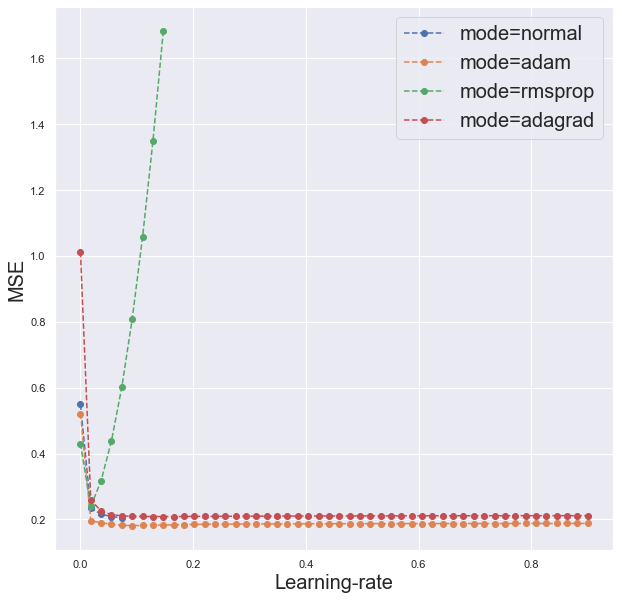

In [361]:
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
fig.set_figheight(10)
fig.set_figwidth(10)

axs.set_xlabel("Learning-rate", fontsize=20)
axs.set_ylabel("MSE", fontsize=20)
axs.set_title(f"", fontsize=24)
for j, mode in enumerate(modes):
    axs.plot(learning_rates, MSE_modes[j], "--o",label=f"mode={mode}")
axs.legend(fontsize=20)
plt.show()

This makes us consider to cases, one small intervall to analyse normal and rmsprop, and one longer to investigate adam and adagrad

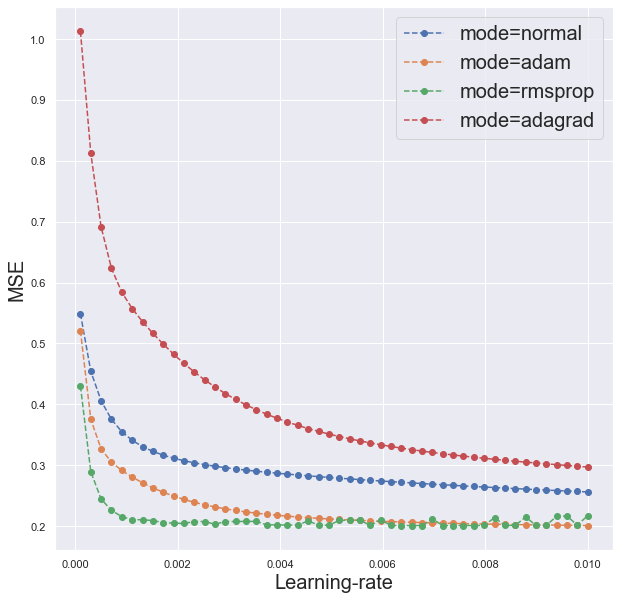

In [373]:
epochs_stop = 1000
learning_rates = np.linspace(0.0001, 0.01)
n_lr = len(learning_rates)

MSE_normal = np.zeros(n_lr)
MSE_adam = np.zeros(n_lr)
MSE_rmsprop = np.zeros(n_lr)
MSE_adagrad = np.zeros(n_lr)
MSE_modes = [MSE_normal, MSE_adam, MSE_rmsprop, MSE_adagrad] #use when plotting


for j, MSE_mode in enumerate(MSE_modes):
    for i, lr in enumerate(learning_rates):
        MSE_mode[i] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, 
                                 mode=modes[j],learning_rate=lr, 
                                 epochs=epochs_stop)
        if MSE_mode[i] > 1.2:
            MSE_mode[i] = np.NaN
        
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
fig.set_figheight(10)
fig.set_figwidth(10)

axs.set_xlabel("Learning-rate", fontsize=20)
axs.set_ylabel("MSE", fontsize=20)
axs.set_title(f"", fontsize=24)
for j, mode in enumerate(modes):
    axs.plot(learning_rates, MSE_modes[j], "--o",label=f"mode={mode}")
axs.legend(fontsize=20)
plt.show()

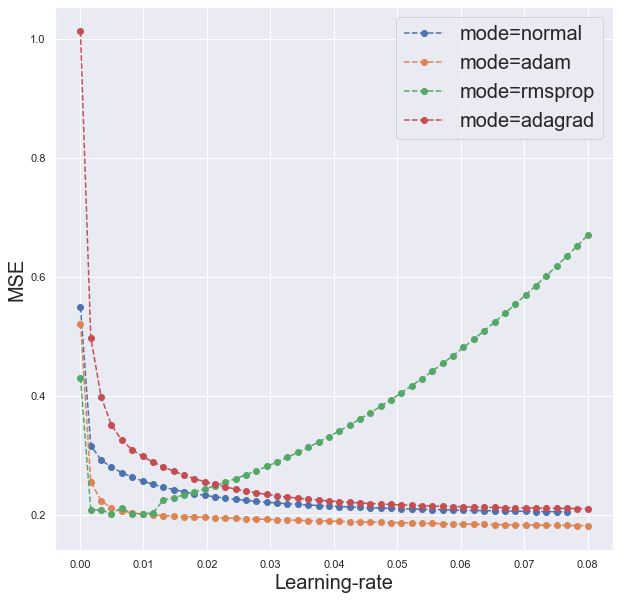

In [377]:
epochs_stop = 1000
learning_rates = np.linspace(0.0001, 0.08)
n_lr = len(learning_rates)

MSE_normal = np.zeros(n_lr)
MSE_adam = np.zeros(n_lr)
MSE_rmsprop = np.zeros(n_lr)
MSE_adagrad = np.zeros(n_lr)
MSE_modes = [MSE_normal, MSE_adam, MSE_rmsprop, MSE_adagrad] #use when plotting


for j, MSE_mode in enumerate(MSE_modes):
    for i, lr in enumerate(learning_rates):
        MSE_mode[i] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, 
                                 mode=modes[j],learning_rate=lr, 
                                 epochs=epochs_stop)
        if MSE_mode[i] > 1.2:
            MSE_mode[i] = np.NaN
            
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
fig.set_figheight(10)
fig.set_figwidth(10)

axs.set_xlabel("Learning-rate", fontsize=20)
axs.set_ylabel("MSE", fontsize=20)
axs.set_title(f"", fontsize=24)
for j, mode in enumerate(modes):
    axs.plot(learning_rates, MSE_modes[j], "--o",label=f"mode={mode}")
axs.legend(fontsize=20)
plt.show()

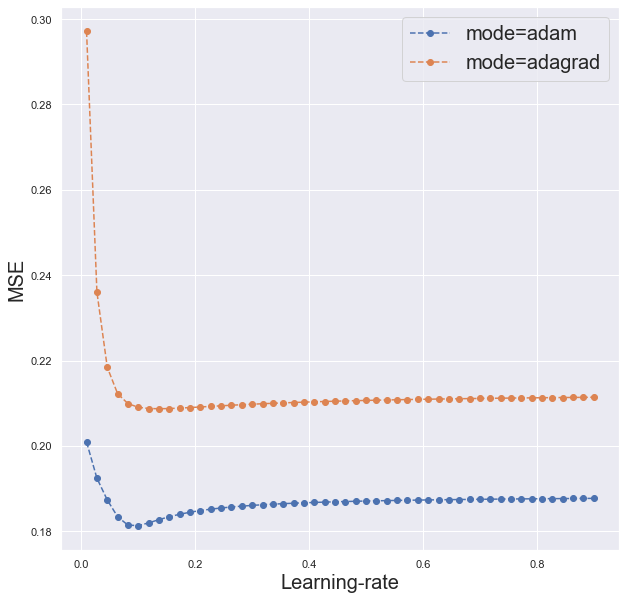

In [379]:
epochs_stop = 1000
learning_rates = np.linspace(0.01, 0.9)
n_lr = len(learning_rates)

modes = ["adam", "adagrad"]
MSE_adam = np.zeros(n_lr)
MSE_adagrad = np.zeros(n_lr)
MSE_modes = [MSE_adam, MSE_adagrad] #use when plotting


for j, MSE_mode in enumerate(MSE_modes):
    for i, lr in enumerate(learning_rates):
        MSE_mode[i] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, 
                                 mode=modes[j],learning_rate=lr, 
                                 epochs=epochs_stop)
        if MSE_mode[i] > 1.2:
            MSE_mode[i] = np.NaN
            
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
fig.set_figheight(10)
fig.set_figwidth(10)

axs.set_xlabel("Learning-rate", fontsize=20)
axs.set_ylabel("MSE", fontsize=20)
axs.set_title(f"", fontsize=24)
for j, mode in enumerate(modes):
    axs.plot(learning_rates, MSE_modes[j], "--o",label=f"mode={mode}")
axs.legend(fontsize=20)
plt.show()

One final plot og MSE for adam and adagrad over epochs for higher learingrates

In [394]:
epochs_stop = 60
n_epochs = epochs_stop + 1
epochs_linspace = np.linspace(0, epochs_stop, n_epochs, dtype=int) #to use in plot
learning_rates = [0.04, 0.09, 0.1]
n_lr = len(learning_rates)

MSE_adam = np.zeros((n_lr, n_epochs))
MSE_adagrad = np.zeros((n_lr, n_epochs))
MSE_modes = [MSE_adam,MSE_adagrad] #use when plotting

for j, MSE_mode in enumerate(MSE_modes):
    for i, lr in enumerate(learning_rates):
        MSE_mode[i] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, 
                                 mode=modes[j],learning_rate=lr, 
                                 epochs=epochs_stop, store_extra=True)

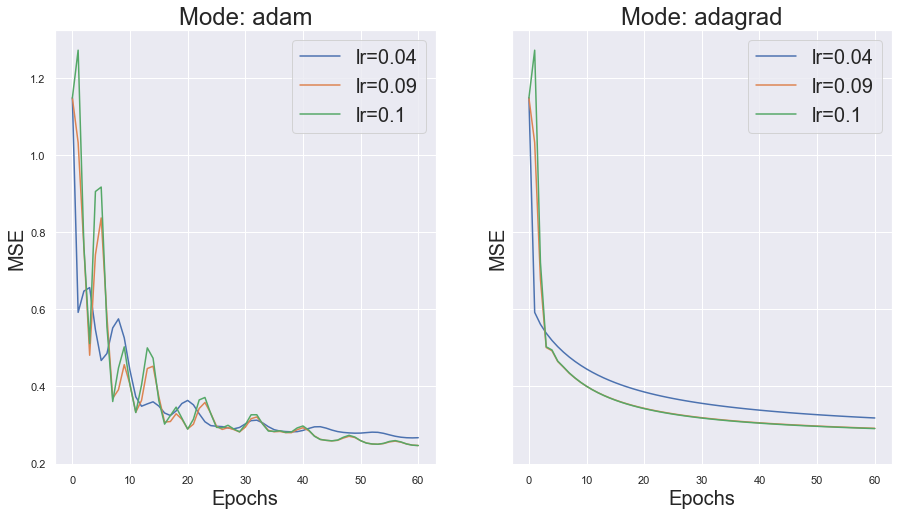

In [395]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
fig.set_figheight(8)
fig.set_figwidth(15)
for i, ax in enumerate(axs.flatten()):
    ax.set_xlabel("Epochs", fontsize=20)
    ax.set_ylabel("MSE", fontsize=20)
    ax.set_title(f"Mode: {modes[i]}", fontsize=24)
    for j, lr in enumerate(learning_rates):
        ax.plot(epochs_linspace, MSE_modes[i][j], label=f"lr={lr}")
    ax.legend(fontsize=20)

# 2. The SGD - Batch-size analysis:

*  Four plots for each mode batch size = 1 for a few different learningrates MSE over Epochs 


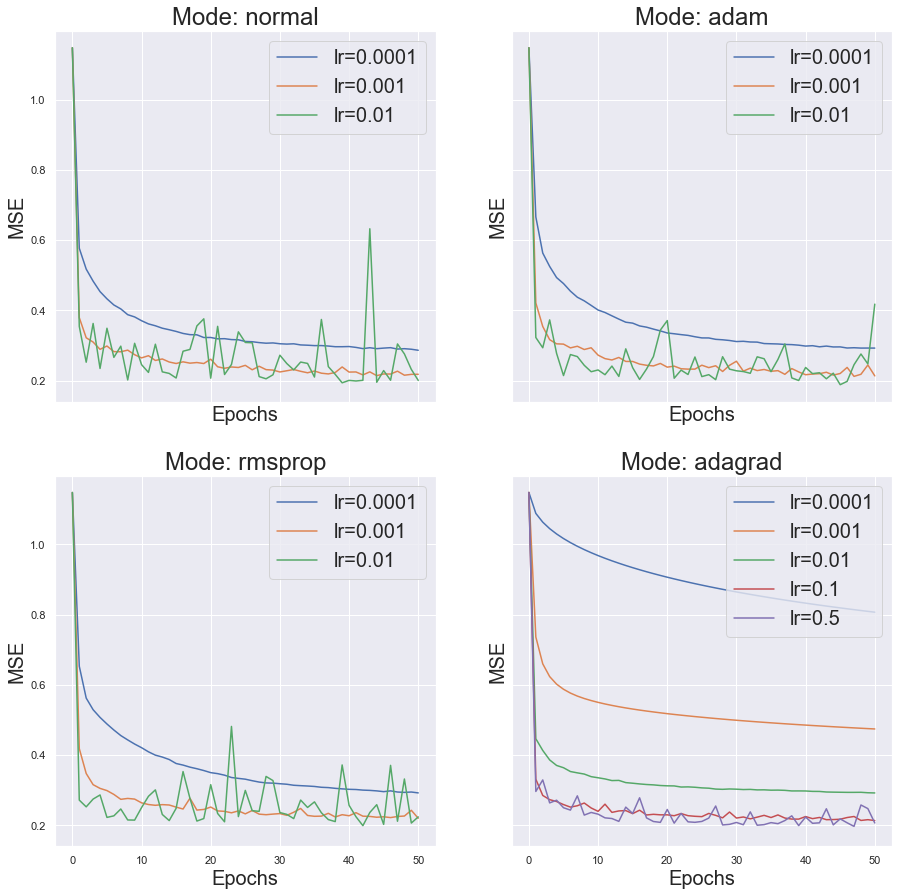

In [412]:
batch_size = 1
epochs_stop = 50
epochs_linspace = np.linspace(0, epochs_stop, epochs_stop + 1, dtype=int)
n_epochs = len(epochs_linspace)
learning_rates = [[0.0001, 0.001, 0.01], #lr for mode = normal
                  [0.0001, 0.001, 0.01], #mode = adam
                  [0.0001, 0.001, 0.01], #rmsprop
                  [0.0001, 0.001, 0.01, 0.1, 0.5]] #adagrad
n_lr = [len(x) for x in learning_rates]

modes = ["normal", "adam", "rmsprop", "adagrad"]
MSE_normal = np.zeros((n_lr[0], n_epochs))
MSE_adam = np.zeros((n_lr[1], n_epochs))
MSE_rmsprop = np.zeros((n_lr[2], n_epochs))
MSE_adagrad = np.zeros((n_lr[3], n_epochs))
MSE_modes = [MSE_normal, MSE_adam, MSE_rmsprop, MSE_adagrad] #use when plotting

for j, MSE_mode in enumerate(MSE_modes):
    for i, lr in enumerate(learning_rates[j]):
        MSE_mode[i] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, 
                                 mode=modes[j],learning_rate=lr, batch_size=batch_size,
                                 epochs=epochs_stop, store_extra=True)
        
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
fig.set_figheight(15)
fig.set_figwidth(15)
for i, ax in enumerate(axs.flatten()):
    ax.set_xlabel("Epochs", fontsize=20)
    ax.set_ylabel("MSE", fontsize=20)
    ax.set_title(f"Mode: {modes[i]}", fontsize=24)
    for j, lr in enumerate(learning_rates[i]):
        ax.plot(epochs_linspace[:50], MSE_modes[i][j][:50], label=f"lr={lr}")
    ax.legend(fontsize=20)

* Four plots (for each mode) MSE over learning rate for 64, 128 and 256    

In [555]:
batch_sizes = [8, 64, 128]
epochs_stop = 1000
n_bs = len(batch_sizes)
n_lr = [20, 20, 20, 20]
lr_range_normal = np.linspace(0.001, 0.04, n_lr[0])
lr_range_adam = np.linspace(0.001, 0.03, n_lr[1])
lr_range_rmsprop = np.linspace(0.0001, 0.009, n_lr[2])
lr_range_adagrad = np.linspace(0.001, 0.5, n_lr[3])
learning_rates = [lr_range_normal, lr_range_adam, lr_range_rmsprop, lr_range_adagrad]

modes = ["normal", "adam", "rmsprop", "adagrad"]
MSE_normal = np.zeros((n_bs, n_lr[0]))
MSE_adam = np.zeros((n_bs, n_lr[1]))
MSE_rmsprop = np.zeros((n_bs, n_lr[2]))
MSE_adagrad = np.zeros((n_bs, n_lr[3]))
MSE_modes = [MSE_normal, MSE_adam, MSE_rmsprop, MSE_adagrad] #use when plotting

for i, MSE_mode in enumerate(MSE_modes):
    for j, bs in enumerate(batch_sizes):
        for k, lr in enumerate(learning_rates[i]):
            MSE_mode[j][k] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, 
                                     mode=modes[i],learning_rate=lr,
                                       batch_size=bs, epochs=epochs_stop)

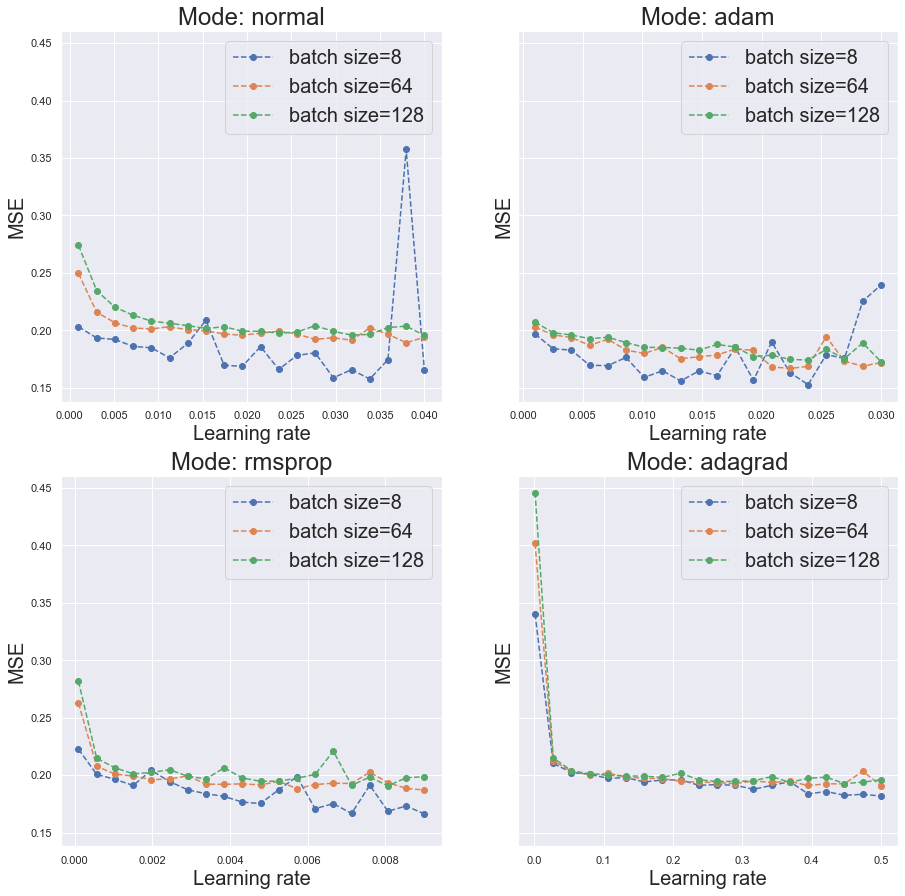

In [556]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharey=True)
fig.set_figheight(15)
fig.set_figwidth(15)
for i, ax in enumerate(axs.flatten()):
    ax.set_xlabel("Learning rate", fontsize=20)
    ax.set_ylabel("MSE", fontsize=20)
    ax.set_title(f"Mode: {modes[i]}", fontsize=24)
    for j, bs in enumerate(batch_sizes):
        ax.plot(learning_rates[i], MSE_modes[i][j][:50], "--o" ,label=f"batch size={bs}")
    ax.legend(fontsize=20)

* MSE over epochs for batch_size 64, 128, 256 - Fixed learning rate - might differ

In [444]:
batch_sizes = [64, 128, 256]
n_bs = len(batch_sizes)
learning_rates = [0.02, 0.025, 0.004, 0.1]
epochs_stop = 1000
epochs_linspace = np.linspace(0, epochs_stop, epochs_stop + 1, dtype=int)
n_epochs = len(epochs_linspace)

modes = ["normal", "adam", "rmsprop", "adagrad"]
MSE_normal = np.zeros((n_bs, n_epochs))
MSE_adam = np.zeros((n_bs, n_epochs))
MSE_rmsprop = np.zeros((n_bs, n_epochs))
MSE_adagrad = np.zeros((n_bs, n_epochs))
MSE_modes = [MSE_normal, MSE_adam, MSE_rmsprop, MSE_adagrad] #use when plotting

for i, MSE_mode in enumerate(MSE_modes):
    for j, bs in enumerate(batch_sizes):
        MSE_mode[j] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, 
                                mode=modes[i],learning_rate=learning_rates[i],
                                batch_size=bs, epochs=epochs_stop,
                               store_extra=True)

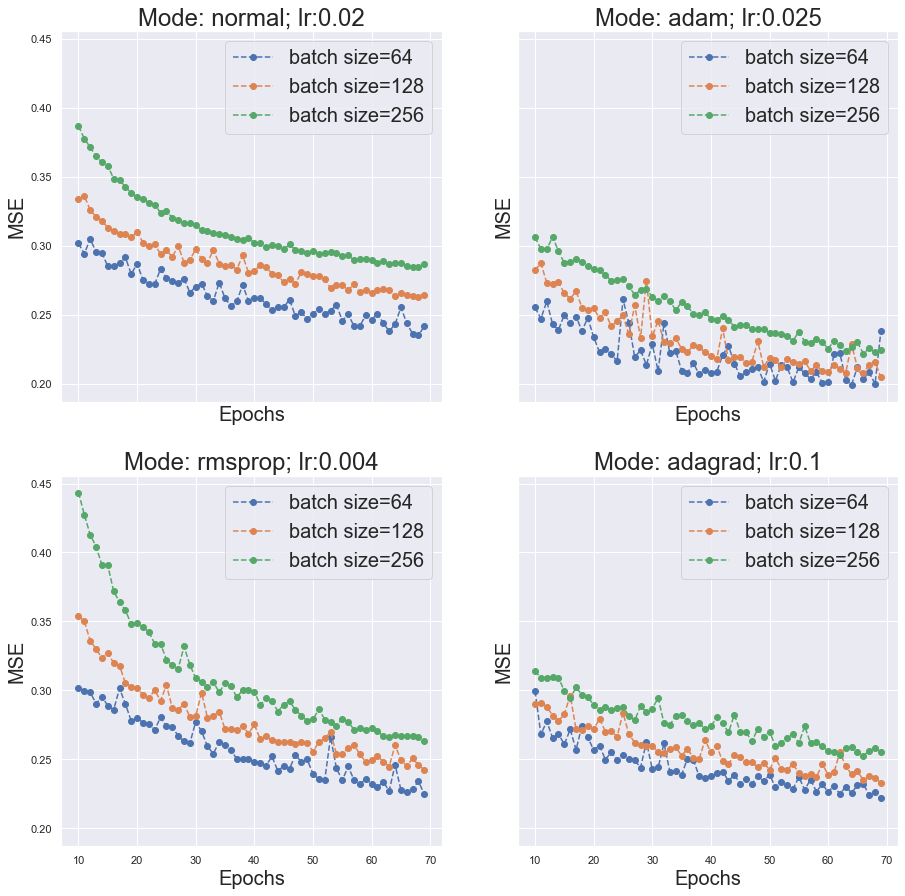

In [449]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
fig.set_figheight(15)
fig.set_figwidth(15)
for i, ax in enumerate(axs.flatten()):
    ax.set_xlabel("Epochs", fontsize=20)
    ax.set_ylabel("MSE", fontsize=20)
    ax.set_title(f"Mode: {modes[i]}; lr:{learning_rates[i]}", fontsize=24)
    for j, bs in enumerate(batch_sizes):
        ax.plot(epochs_linspace[10:70], MSE_modes[i][j][10:70], "--o" ,label=f"batch size={bs}")
    ax.legend(fontsize=20)

* A set learning-rates, equal for all = 0.004

In [450]:
batch_sizes = [64, 128, 256]
n_bs = len(batch_sizes)
learning_rates = [0.004, 0.004, 0.004, 0.004]
epochs_stop = 1000
epochs_linspace = np.linspace(0, epochs_stop, epochs_stop + 1, dtype=int)
n_epochs = len(epochs_linspace)

modes = ["normal", "adam", "rmsprop", "adagrad"]
MSE_normal = np.zeros((n_bs, n_epochs))
MSE_adam = np.zeros((n_bs, n_epochs))
MSE_rmsprop = np.zeros((n_bs, n_epochs))
MSE_adagrad = np.zeros((n_bs, n_epochs))
MSE_modes = [MSE_normal, MSE_adam, MSE_rmsprop, MSE_adagrad] #use when plotting

for i, MSE_mode in enumerate(MSE_modes):
    for j, bs in enumerate(batch_sizes):
        MSE_mode[j] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, 
                                mode=modes[i],learning_rate=learning_rates[i],
                                batch_size=bs, epochs=epochs_stop,
                               store_extra=True)

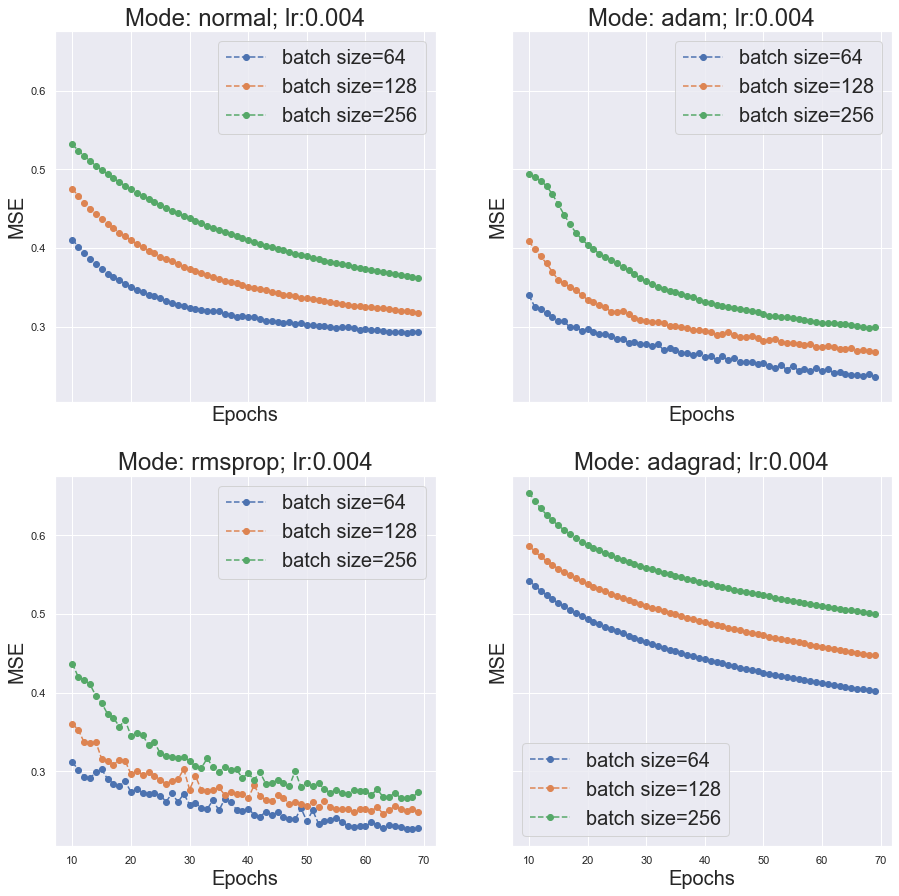

In [451]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
fig.set_figheight(15)
fig.set_figwidth(15)
for i, ax in enumerate(axs.flatten()):
    ax.set_xlabel("Epochs", fontsize=20)
    ax.set_ylabel("MSE", fontsize=20)
    ax.set_title(f"Mode: {modes[i]}; lr:{learning_rates[i]}", fontsize=24)
    for j, bs in enumerate(batch_sizes):
        ax.plot(epochs_linspace[10:70], MSE_modes[i][j][10:70], "--o" ,label=f"batch size={bs}")
    ax.legend(fontsize=20)

# 3. Momentum analysis:

* MSE over momentum 4 plots (Equal Axis) for a few different learning rates   

kmt: batch size = 256 to avoid randomness from batchsizes

In [565]:
epochs_stop = 2000
batch_size = 128

n_mom = 10
momentum_range = np.linspace(0, 0.8, n_mom)
lr_normal = [0.00001, 0.0001, 0.001, 0.01, 0.04]
lr_adam = [0.00001, 0.0001, 0.0005, 0.0007]
lr_rmsprop = [0.00001, 0.0001, 0.001, 0.01, 0.04] 
lr_adagrad = [0.00001, 0.0001, 0.001, 0.01, 0.04]
learning_rates = [lr_normal, lr_adam, lr_rmsprop, lr_adagrad]

modes = ["normal", "adam", "rmsprop", "adagrad"]
MSE_normal = np.zeros((len(learning_rates[0]), n_mom))
MSE_adam = np.zeros((len(learning_rates[1]), n_mom))
MSE_rmsprop = np.zeros((len(learning_rates[2]), n_mom))
MSE_adagrad = np.zeros((len(learning_rates[3]), n_mom))
MSE_modes = [MSE_normal, MSE_adam, MSE_rmsprop, MSE_adagrad] #use when plotting

for i, MSE_mode in enumerate(MSE_modes):
    for j, lr in enumerate(learning_rates[i]):
        for k, mom in enumerate(momentum_range):
            MSE_mode[j][k] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, 
                                    mode=modes[i],learning_rate=lr, momentum=mom,
                                    batch_size=batch_size, epochs=epochs_stop)

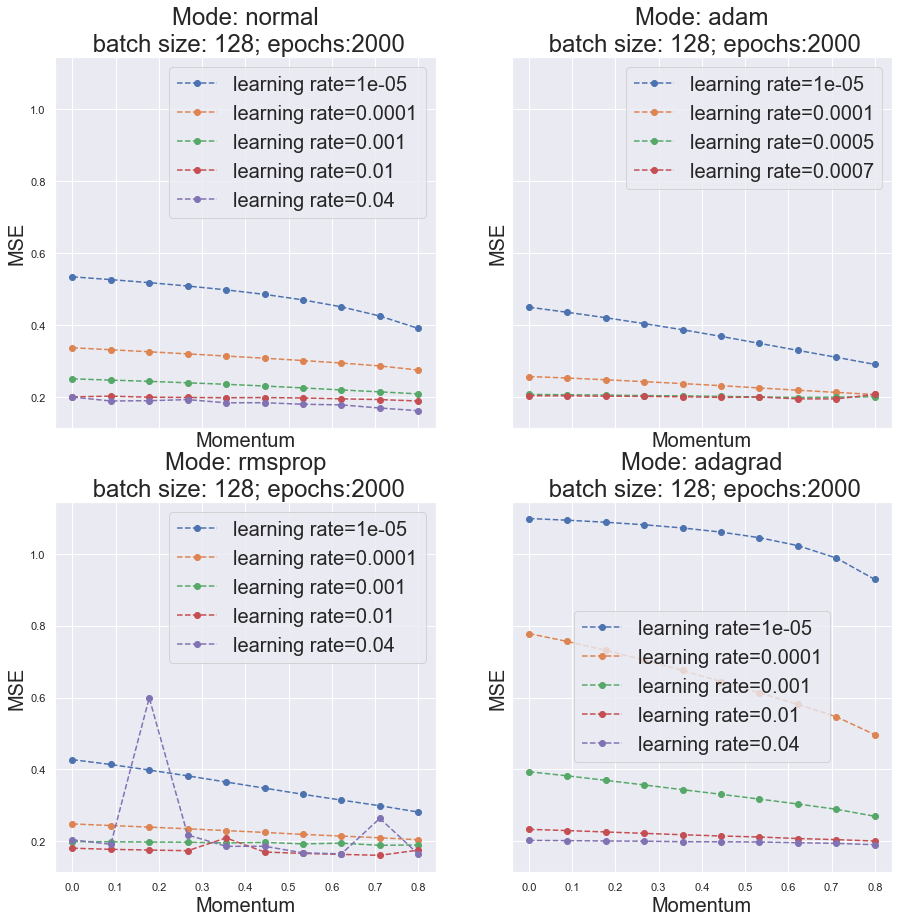

In [566]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
fig.set_figheight(15)
fig.set_figwidth(15)
for i, ax in enumerate(axs.flatten()):
    ax.set_xlabel("Momentum", fontsize=20)
    ax.set_ylabel("MSE", fontsize=20)
    ax.set_title(f"Mode: {modes[i]}\n batch size: {batch_size}; epochs:{epochs_stop}", fontsize=24)
    for j, lr in enumerate(learning_rates[i]):
        ax.plot(momentum_range, MSE_modes[i][j], "--o" ,label=f"learning rate={lr}")
    ax.legend(fontsize=20)

Legger til forskjellige momentum ranges for de ulike modene. 

In [527]:
n_mom = 10
momentum_range_normal = np.linspace(0, 0.9, n_mom)
momentum_range_adam = np.linspace(0, 0.5, n_mom)
momentum_range_rmsprop = np.linspace(0, 0.9, n_mom)
momentum_range_adagrad = np.linspace(0, 0.9, n_mom)

momentum_ranges = [momentum_range_normal, momentum_range_adam,
                  momentum_range_rmsprop, momentum_range_adagrad]

lr_normal = [0.001, 0.01, 0.05]
lr_adam = [0.001, 0.01, 0.05, 0.08]
lr_rmsprop = [0.001, 0.01, 0.05] 
lr_adagrad = [0.001, 0.01, 0.05]
learning_rates = [lr_normal, lr_adam, lr_rmsprop, lr_adagrad]

modes = ["normal", "adam", "rmsprop", "adagrad"]
MSE_normal = np.zeros((len(learning_rates[0]), n_mom))
MSE_adam = np.zeros((len(learning_rates[1]), n_mom))
MSE_rmsprop = np.zeros((len(learning_rates[2]), n_mom))
MSE_adagrad = np.zeros((len(learning_rates[3]), n_mom))
MSE_modes = [MSE_normal, MSE_adam, MSE_rmsprop, MSE_adagrad] #use when plotting

for i, MSE_mode in enumerate(MSE_modes):
    for j, lr in enumerate(learning_rates[i]):
        for k, mom in enumerate(momentum_ranges[i]):
            MSE_mode[j][k] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, 
                                    mode=modes[i],learning_rate=lr, momentum=mom,
                                    batch_size=batch_size, epochs=epochs_stop)

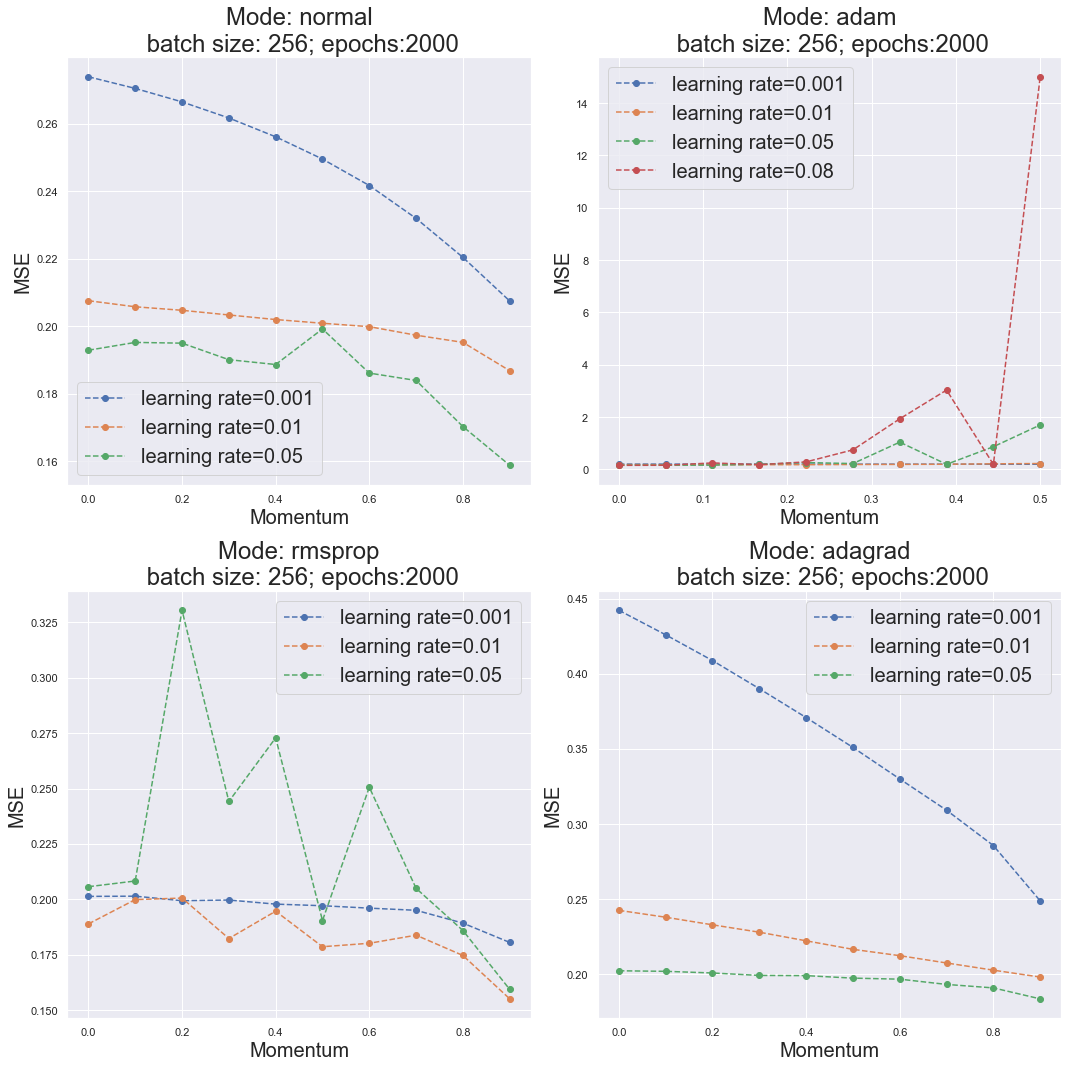

In [528]:
fig, axs = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(15)
fig.set_figwidth(15)
for i, ax in enumerate(axs.flatten()):
    ax.set_xlabel("Momentum", fontsize=20)
    ax.set_ylabel("MSE", fontsize=20)
    ax.set_title(f"Mode: {modes[i]}\n batch size: {batch_size}; epochs:{epochs_stop}", fontsize=24)
    for j, lr in enumerate(learning_rates[i]):
        ax.plot(momentum_ranges[i], MSE_modes[i][j], "--o" ,label=f"learning rate={lr}")
    ax.legend(fontsize=20)
plt.tight_layout()

* MSE over Epochs 4 plots (Equal Axis) for a few different momentum set learing rates 

In [585]:
epochs_stop = 2000
n_epochs = epochs_stop +1
batch_size = 256
epochs_linspace = np.linspace(0, epochs_stop, epochs_stop + 1, dtype=int)

lr_normal = 0.01;lr_adam= 0.001; lr_rmsprop=0.01; lr_adagrad=0.06 
learning_rates = [lr_normal, lr_adam, lr_rmsprop, lr_adagrad]

mom_normal = [0.6, 0.7 ,0.9]
mom_adam = [0, 0.02, 0.04, 0.2, 0.7]
mom_rmsprop = [0.6, 0.7, 0.9]
mom_adagrad = [0.6, 0.7, 0.9, 0.99]
momentum_modes = [mom_normal, mom_adam, mom_rmsprop, mom_adagrad]

modes = ["normal", "adam", "rmsprop", "adagrad"]
MSE_normal = np.zeros((n_mom, n_epochs))
MSE_adam = np.zeros((n_mom, n_epochs))
MSE_rmsprop = np.zeros((n_mom, n_epochs))
MSE_adagrad = np.zeros((n_mom, n_epochs)) 
MSE_modes = [MSE_normal, MSE_adam, MSE_rmsprop, MSE_adagrad] #use when plotting


for i, MSE_mode in enumerate(MSE_modes):
    lr = learning_rates[i]
    for k, mom in enumerate(momentum_modes[i]):
        MSE_mode[k] = find_MSE(X_train, X_test, z_train, z_test, w_init, model, 
                                    mode=modes[i],learning_rate=lr, momentum=mom,
                                    batch_size=batch_size, epochs=epochs_stop,
                              store_extra=True)

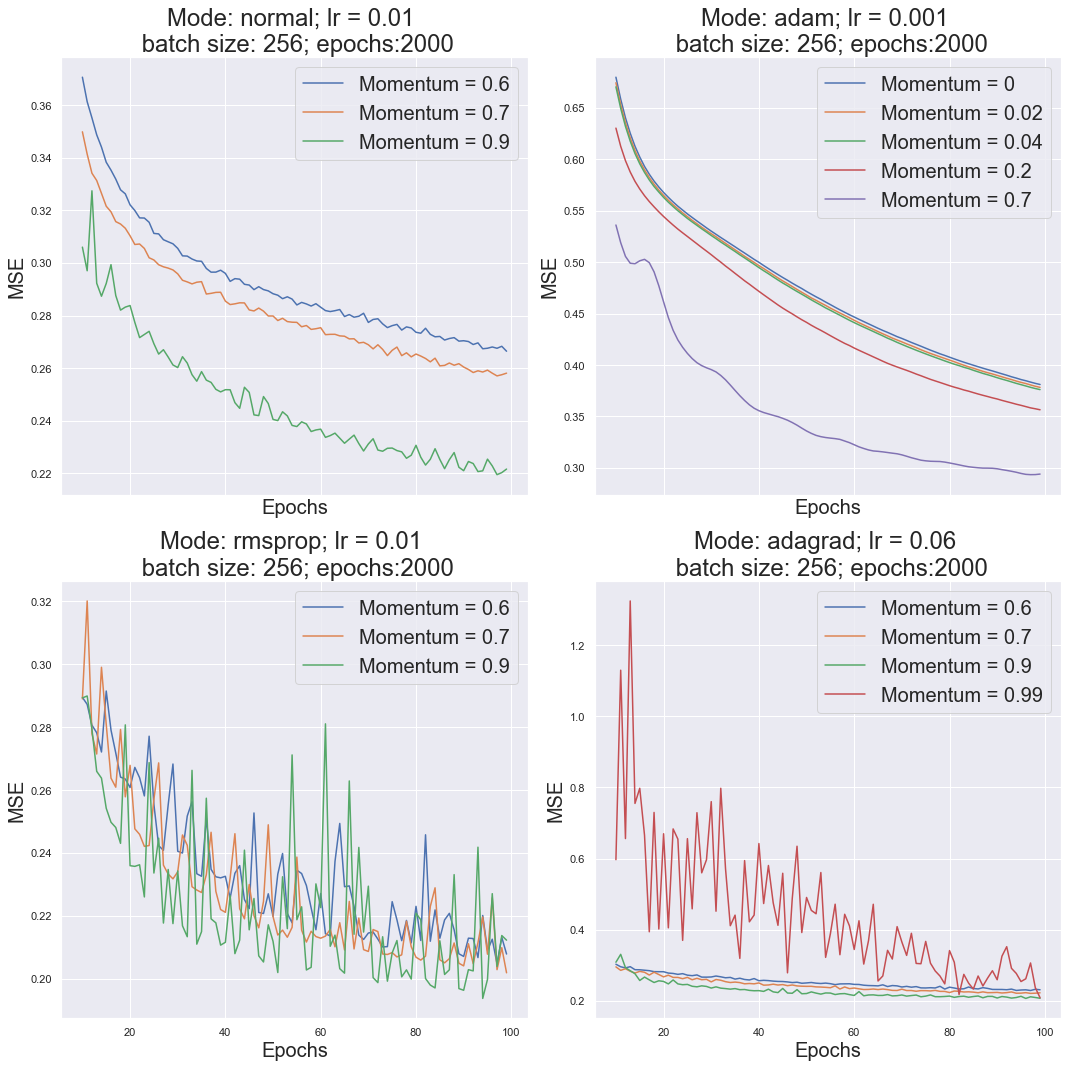

In [588]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True)
fig.set_figheight(15)
fig.set_figwidth(15)
for i, ax in enumerate(axs.flatten()):
    ax.set_xlabel("Epochs", fontsize=20)
    ax.set_ylabel("MSE", fontsize=20)
    ax.set_title(f"Mode: {modes[i]}; lr = {learning_rates[i]} \n batch size: {batch_size}; epochs:{epochs_stop}", fontsize=24)
    for j, mom in enumerate(momentum_modes[i]):
        ax.plot(epochs_linspace[10:100], MSE_modes[i][j][10:100] ,label=f"Momentum = {mom}")
    ax.legend(fontsize=20)
plt.tight_layout()

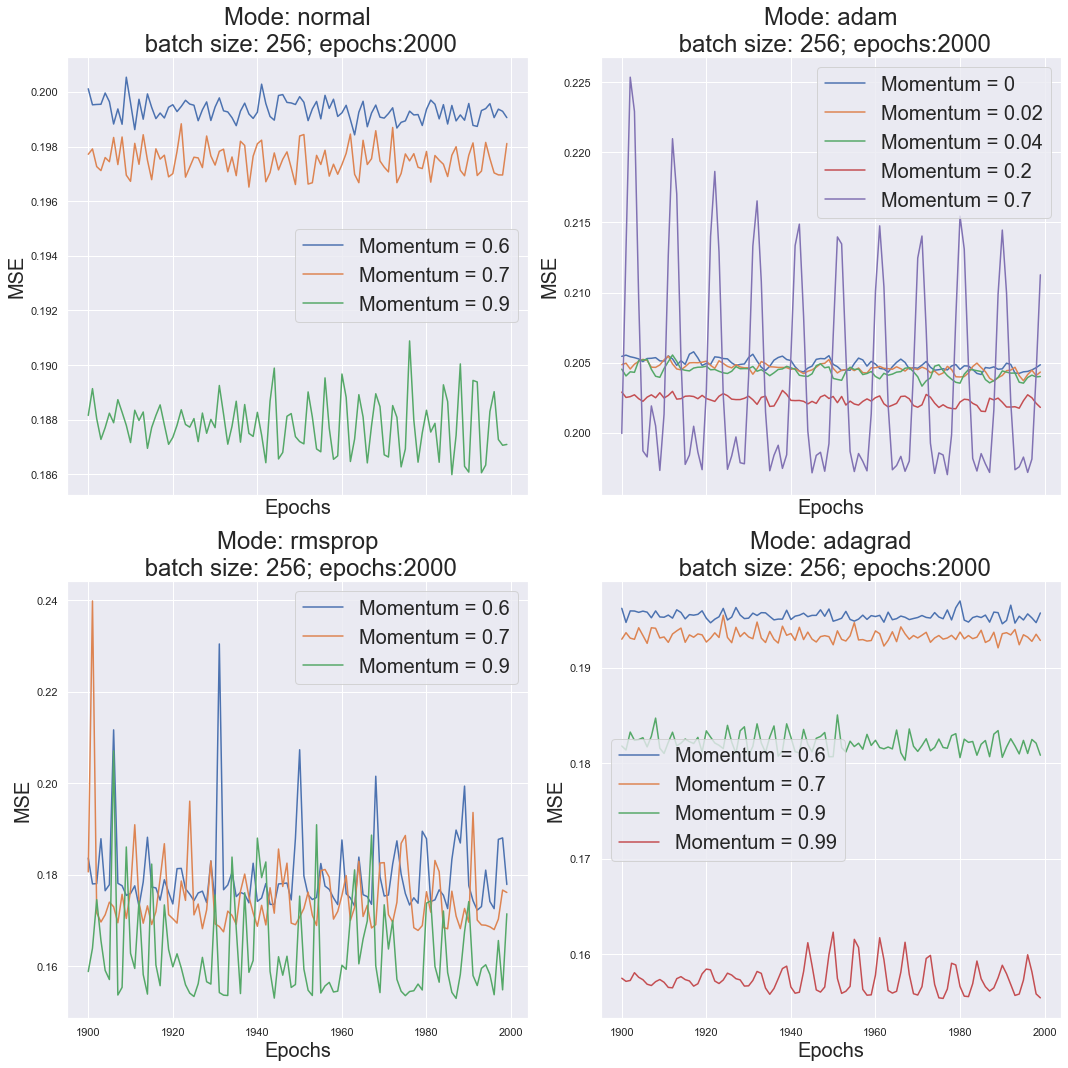

In [587]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True)
fig.set_figheight(15)
fig.set_figwidth(15)
for i, ax in enumerate(axs.flatten()):
    ax.set_xlabel("Epochs", fontsize=20)
    ax.set_ylabel("MSE", fontsize=20)
    ax.set_title(f"Mode: {modes[i]}\n batch size: {batch_size}; epochs:{epochs_stop}", fontsize=24)
    for j, mom in enumerate(momentum_modes[i]):
        ax.plot(epochs_linspace[1900:2000], MSE_modes[i][j][1900:2000] ,label=f"Momentum = {mom}")
    ax.legend(fontsize=20)
plt.tight_layout()

4. SKlearn:
    
    * TODO: Find out where a comperison with SKlearn could be relevant. 
    
        *  Some limitations here: SKlearn do not have Store extra option
        
        * You can not choose batch size (set to one)
        
            * Check if adam a.s.o can be choosen, and momentum

# 5. Grid search: (random/limited area)
    
* Four plots, grid search over lambda and learningrate

    * we do this for each mode

We want to find optimal l2 regulariserings parameter aswell as optimal learning-rate. Do to constraint in computing-power we have to choose a subset of combinations to test for.
We do this by estimating a range for each paramterer based on the analysis above

In [509]:
def grid_search(X, z, lambda_range, lr_range, momentum=0.9, mode="normal", store_extra = False):
    
    X_train, X_test, X_validation = X
    z_train, z_test, z_validation = z
    
    #set mini-bach size
    batch_size = 256
    #set nr of epochs
    epochs = 2000
    
    m = momentum
    
    optimal = [None, None]
    optimal_MSE = 1000
    MSE_grid = np.zeros((len(lr_range), len(lambda_range)))
    w_log = 0
    
    progress = 0
    
    for num1, i in enumerate(lambda_range):
        model = rcf.RidgeCost(i)
        progress += 100/len(lambda_range)
        for num2, j in enumerate(lr_range):
            #init weights
            w_init = np.zeros(len(X_train[0]))
            #Make model with i and j param
            descent = gd.GradientDescent(mode=mode, momentum_param=m, batch_size=batch_size, store_extra=store_extra)
            w = descent.train(X_train, w_init, z_train, model, learning_rate=j, n_epochs = epochs)
            #calculate MSE 
            mse = rt.MSE(z_test, X_test@w.flatten())
            if mse<optimal_MSE:
                optimal_MSE = mse
                optimal = [i, j]
                if store_extra:   
                    w_log = descent.weights
            MSE_grid[num2, num1] = mse
        print(f"progress = {progress:.2f}%", end="\r")
    
    if store_extra:
        return optimal, optimal_MSE, MSE_grid, w_log
    else:
        return optimal, optimal_MSE, MSE_grid

In [510]:
X = (X_train, X_test, 0)
z = (z_train, z_test, 0)
#lamda_range = np.linspace(0.01, 0.1 , 15)
#lr_range = np.linspace(0, 0.9, 15)

M, N = np.meshgrid(lamda_range, lr_range)

In [523]:
lambda_range = np.logspace(-5, -2, 5)
lr_range = np.linspace(0, 0.1, 10)
optimal, optimal_MSE, MSE_grid = grid_search(X, z, lambda_range, lr_range)

In [597]:
import seaborn as sns
sns.set()
modes = ["normal", "adam", "rmsprop", "adagrad"]
g, q, MSE_grid_normal = grid_search(X, z, lambda_range, lr_range, mode="normal")
g, q, MSE_grid_adam = grid_search(X, z, lambda_range, lr_range, mode="adam")
g, q, MSE_grid_rmsprop = grid_search(X, z, lambda_range, lr_range, mode="rmsprop")
g, q, MSE_grid_adagrad = grid_search(X, z, lambda_range, lr_range, mode="adagrad")
MSE_grid_modes = [MSE_grid_normal, MSE_grid_adam, MSE_grid_rmsprop, MSE_grid_adagrad]

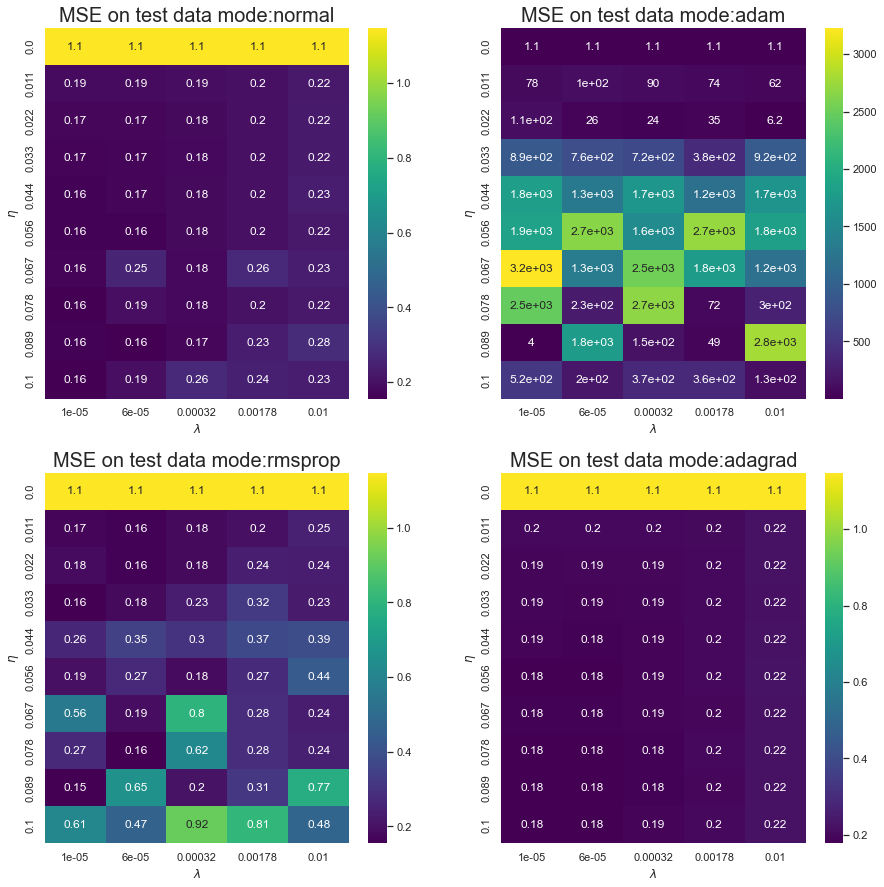

In [596]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (15, 15))
for i, ax in enumerate(axs.flatten()):
    sns.heatmap(MSE_grid_modes[i], annot=True, ax=ax, cmap="viridis")
    ax.set_title(f"MSE on test data mode:{modes[i]}", fontsize=20)
    ax.set_yticklabels(lr_range.round(3))
    ax.set_xticklabels(lambda_range.round(5), )
    ax.set_ylabel("$\eta$")
    ax.set_xlabel("$\lambda$")
plt.show()

# OLD PART:

In [ ]:
import matplotlib.colors as colors
X = (X_train, X_test, 0)
z = (z_train, z_test, 0)
lamda_range = np.linspace(0.01, 0.1 , 15)
lr_range = np.linspace(0, 0.9, 15)

M, N = np.meshgrid(lamda_range, lr_range)

In [ ]:
print("RMS")
opt_rms = grid_search(X, z, lamda_range, lr_range, mode="rmsprop")

In [ ]:
print("Adam")
opt_adam = grid_search(X, z, lamda_range, lr_range, momentum = 0, mode="adam")

In [ ]:
print("Adagrad")
opt_adagrad = grid_search(X, z, lamda_range, lr_range, mode="adagrad")

In [ ]:
# Make a plot with more levels at low values with 50 levels
# RMS
plt.contourf(M, N, opt_rms[2], cmap="viridis")
plt.colorbar()
plt.xlabel("Lambda")
plt.ylabel("Learning rate")
plt.show()

In [ ]:
# Make a plot with 20 levels between 41 and 42
# ADAgrad
plt.contourf(M, N, opt_adagrad[2], cmap="viridis", levels=np.linspace(0.008, 0.009, 10))
plt.colorbar()
plt.xlabel("Lambda")
plt.ylabel("Learning rate")
plt.show()

In [ ]:
# Make a countourf plot
# ADAM
plt.contourf(M, N, opt_adam[2], cmap="viridis", levels=np.linspace(0, 0.1, 100))
plt.colorbar()
plt.xlabel("Lambda")
plt.ylabel("Learning rate")
plt.show()

## Plot MSE over epocs for the best model of each mode "adam", "rmsprop" and "adagrad"

In [ ]:
opt_rms_weights = grid_search(X, z, lamda_range, lr_range, mode="rmsprop", store_extra=True)

In [ ]:
opt_adam_weights = grid_search(X, z, lamda_range, lr_range, momentum = 0, mode="adam", store_extra=True)

In [ ]:
opt_adagrad_weights = grid_search(X, z, lamda_range, lr_range, mode="adagrad", store_extra=True)

In [ ]:
epochs = 2000
epoc_arr = np.linspace(0, epochs, epochs+1)

#RMS_prop
wlog_adagrad = opt_adagrad_weights[3]
wlog_rms = opt_rms_weights[3]
wlog_adam = opt_adam_weights[3]

# y_pred as an array corrosponding to predictiv y for each epoch 
z_pred_rms = (X_test@wlog_rms.T).T
z_pred_adam = (X_test@wlog_adam.T).T
z_pred_adagrad = (X_test@wlog_adagrad.T).T


MSE_rms = rt.MSE_vec(z_test, z_pred_rms)
MSE_adam = rt.MSE_vec(z_test, z_pred_adam)
MSE_adagrad = rt.MSE_vec(z_test, z_pred_adagrad)

plt.plot(epoc_arr[:10], MSE_rms[:10], label="rms_prop")
plt.plot(epoc_arr[:10], MSE_adam[:10], label="adam")
plt.plot(epoc_arr[:10], MSE_adagrad[:10], label="adagrad")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.show()

# Grid-search for momentum

In [ ]:
def grid_search_momentum(X, z, lambda_range, lr_range, momentum_range, mode="normal", store_extra = False):
    
    X_train, X_test, X_validation = X
    z_train, z_test, z_validation = z
    
    #set mini-bach size
    batch_size = 256
    #set nr of epochs
    epochs = 2000
    
    optimal = [None, None, None]
    optimal_MSE = 1000
    MSE_grid = np.zeros((len(momentum_range), len(lr_range), len(lambda_range)))
    w_log = 0
    
    progress = 0
    
    for num1, i in enumerate(lambda_range):
        model = rcf.RidgeCost(i)
        progress += 100/len(lambda_range)
        for num2, j in enumerate(lr_range):
            for num3, k in enumerate(momentum_range):
                #init weights
                w_init = np.zeros(len(X_train[0]))
                #Make model with i and j param
                descent = gd.GradientDescent(mode=mode, momentum_param=k, batch_size=batch_size, store_extra=store_extra)
                w = descent.train(X_train, w_init, z_train, model, learning_rate=j, n_epochs = epochs)
                #calculate MSE 
                mse = rt.MSE(z_test, X_test@w.flatten())
                if mse<optimal_MSE:
                    optimal_MSE = mse
                    optimal = [i, j, k]
                    if store_extra:   
                        w_log = descent.weights
                MSE_grid[num3, num2, num1] = mse
        print(f"progress = {progress:.2f}%", end="\r")
    
    if store_extra:
        return optimal, optimal_MSE, MSE_grid, w_log
    else:
        return optimal, optimal_MSE, MSE_grid

In [ ]:
X = (X_train, X_test, 0)
z = (z_train, z_test, 0)
lamda_range = np.linspace(0, 0.5, 6)
lr_range = np.linspace(0.1, 0.4, 4)
momentum_range = np.linspace(0, 0.95, 10)

M, N = np.meshgrid(lamda_range, lr_range)

In [ ]:
print("Adagrad")
opt_adagrad = grid_search_momentum(X, z, lamda_range, lr_range, momentum_range, mode="adagrad")

In [ ]:
print(opt_adagrad)